# Decision Trees

## Graphviz

### Installing graphviz

In [ ]:
!apt install -y graphviz
!pip install graphviz

### A tree example

In [0]:
from graphviz import Digraph

styles = {
    'top': {'shape': 'ellipse', 'style': 'filled', 'color': 'lightblue'},
    'no':  {'shape': 'circle', 'style': 'filled', 'color': 'red'},
    'yes': {'shape': 'circle', 'style': 'filled', 'color': 'lightgreen'},
    'qst': {'shape': 'rect'}
}

example_tree = Digraph()

example_tree.node('top', 'Should I attend the ML lecture?', styles['top'])
example_tree.node('q1', 'Do I fulfill requirements?', styles['qst'])

example_tree.node('q2', 'Do I like CS?', styles['qst'])
example_tree.node('no1', 'No ', styles['no'])

example_tree.node('q3', 'Is the lecture early in the morning?', styles['qst'])
example_tree.node('no2', 'No ', styles['no'])

example_tree.node('no3', 'No ', styles['no'])
example_tree.node('yes', 'Yes', styles['yes'])

example_tree.edge('top', 'q1')

example_tree.edge('q1', 'q2', 'Yes')
example_tree.edge('q1', 'no1', 'No')

example_tree.edge('q2', 'q3', 'Yes')
example_tree.edge('q2', 'no2', 'No')

example_tree.edge('q3', 'no3', 'Yes')
example_tree.edge('q3', 'yes', 'No')

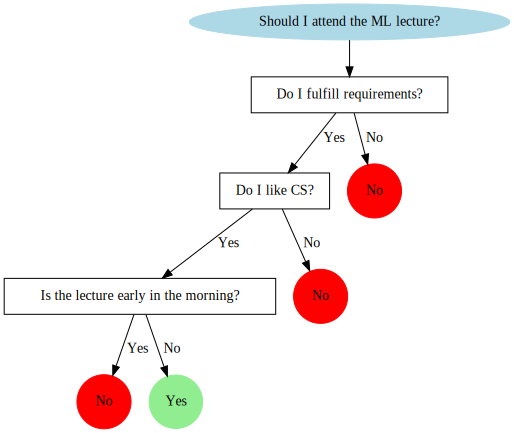

In [0]:
example_tree

## Introduction

### Decision trees

* Supervised learning algorithm - training dataset with known labels

* Eager learning - final model does not need training data to make prediction (all parameters are evaluated during learning step)

* It can do both classification and regression

* A decision tree is built from:

    * **decision nodes** - correspond to features (attributes)
    * **leaf nodes** - correspond to class labels
    
* The **root** of a tree is (should be) the best predictor (feature)


### Example

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')

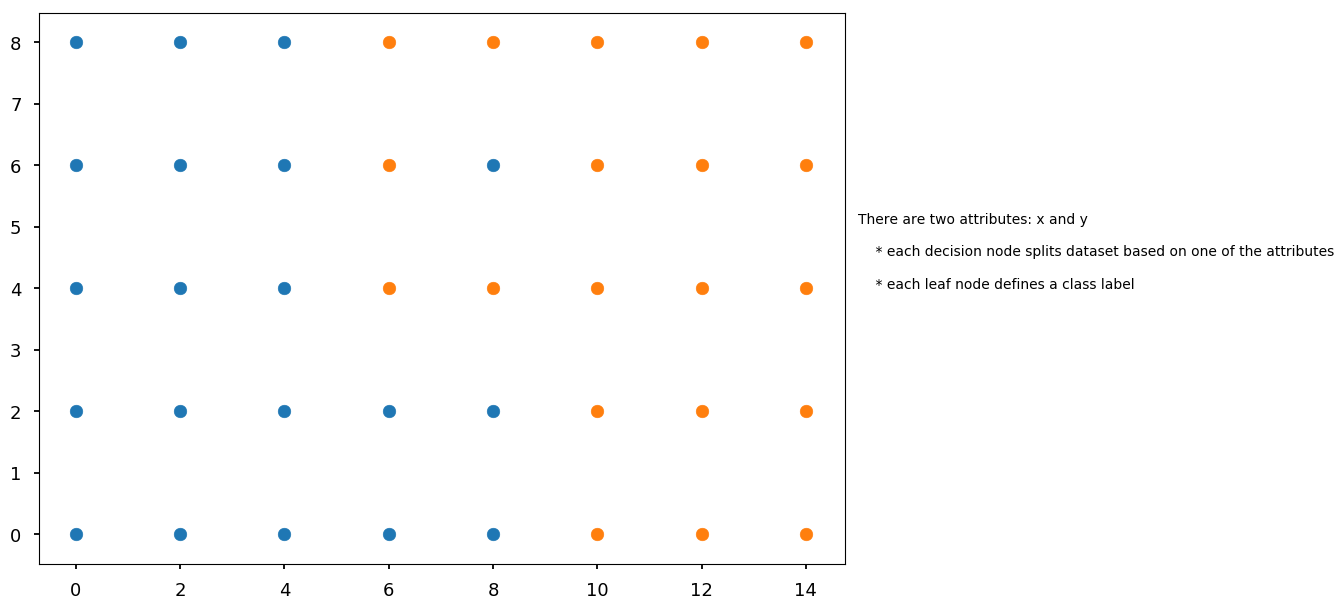

In [0]:
# first define some points representing two classes
grid = np.mgrid[0:10:2, 0:10:2]
set01 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set01 = np.delete(set01, [17, 18, 19, 22, 24], axis=0)

grid = np.mgrid[6:16:2, 0:10:2]
set02 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set02 = np.delete(set02, [0, 1, 5, 6, 8], axis=0)

plt.scatter(*set01.T)
plt.scatter(*set02.T)

plt.text(15, 4, "There are two attributes: x and y\n\n"
                "    * each decision node splits dataset based on one of the attributes\n\n"
                "    * each leaf node defines a class label");

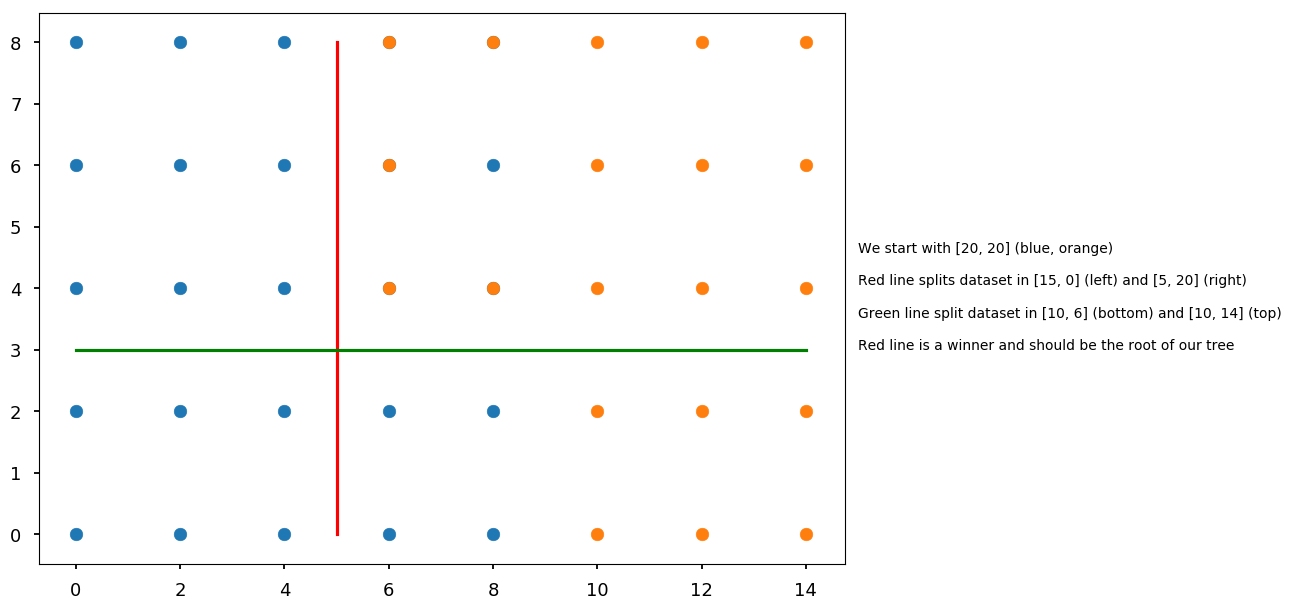

In [0]:
plt.scatter(*set01.T)
plt.scatter(*set02.T)

plt.plot([5, 5], [0, 8], 'r')
plt.plot([0, 14], [3, 3], 'g')

plt.text(15, 3, "We start with [20, 20] (blue, orange)\n\n"
                "Red line splits dataset in [15, 0] (left) and [5, 20] (right)\n\n"
                "Green line split dataset in [10, 6] (bottom) and [10, 14] (top)\n\n"
                "Red line is a winner and should be the root of our tree");

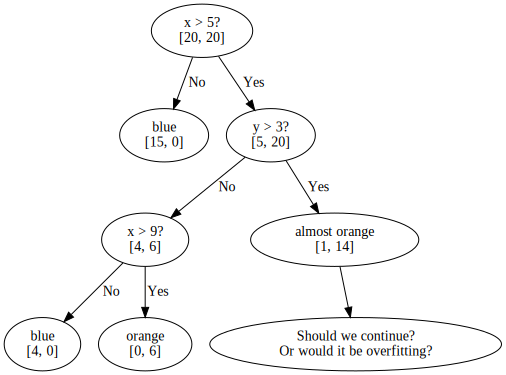

In [0]:
tree = Digraph()

tree.edge("x > 5?\n[20, 20]", "blue\n[15, 0]", "No")
tree.edge("x > 5?\n[20, 20]", "y > 3?\n[5, 20]", "Yes")

tree.edge("y > 3?\n[5, 20]", "x > 9?\n[4, 6]", "No")
tree.edge("y > 3?\n[5, 20]", "almost orange\n[1, 14]", "Yes")

tree.edge("x > 9?\n[4, 6]", "blue\n[4, 0]", "No")
tree.edge("x > 9?\n[4, 6]", "orange\n[0, 6]", "Yes")

tree.edge("almost orange\n[1, 14]", "Should we continue?\nOr would it be overfitting?")

tree

* It is important to start with good predictor

    * Our choice of the root classifies 37.5% of points  in the first step
    
    * Note, that we could also start with `x > 9?`
    
    * However, if we started with `y > 3` we would never classify a point in the first step - does it mean that it is worse choice?

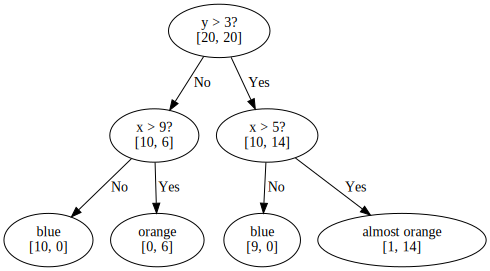

In [0]:
tree = Digraph()

tree.edge("y > 3?\n[20, 20]", "x > 9?\n[10, 6]", "No")
tree.edge("y > 3?\n[20, 20]", "x > 5?\n[10, 14]", "Yes")

tree.edge("x > 9?\n[10, 6]", "blue\n[10, 0]", "No")
tree.edge("x > 9?\n[10, 6]", "orange\n[0, 6]", "Yes")

tree.edge("x > 5?\n[10, 14]", "blue\n[9, 0]", "No")
tree.edge("x > 5?\n[10, 14]", "almost orange\n[1, 14]", "Yes")

tree

* In this case we never have to make more than 2 checks

* There are two open questions to answer:

    * How to automate the procees of chosing nodes?
    
    * How deep should we go?

## ID3 and C4.5 algorithms

* We start with algorithms based on information theory

    * ID3 (Iterative Dichotomiser 3)
    
    * C4.5 - extension of ID3 (why C4.5? C stands for programming language and 4.5 for version?)
    
    * C5.0/See5 - improved C4.5 (commercial; single-threaded Linux version is available under GPL though)
    
* The idea is to find nodes which maximize information gain

### Information gain

#### Self-information

* Let $X = (x_1, x_2, ..., x_n)$ be our *information source* (feature), e.g. weather condition: $x_1$ = sunny, $x_2$ = overcast, $x_3$ = rainy

* And let $P = (p_1, p_2, ..., p_n)$ be corresponding probrability distribution (or more precisely - probability mass function)

* We want some measure of information $I$ provided by an event. It should satisfy the following properties:

    * $I$ depends only on the probability of $x_i$, thus $I \equiv I(p_i)$
    
    * $I$ is continuous and deacreasing function of $p_i$
    
    * $I$ is non-negative and $I(1) = 0$
    
    * if $p_i = p_{i, 1} \cdot p_{i, 2}$ (independent events) then $I(p_i) = I(p_{i, 1}) + I(p_{i, 2})$
    
* Logarithmic function satisfies all above condition, so we define self-information as: <p align="center"><br>$I(p) = -\log(p)$</p><br>

    * The most common log base is **2** and then information is in **shannons (Sh)**, also known as **bits**
    
    * In the case of **natural logarithm** the unit is **nat** (natural unit of information)
    
    * In the case of base **10** the unit is **hartley (Hart)**, also known as **dit**

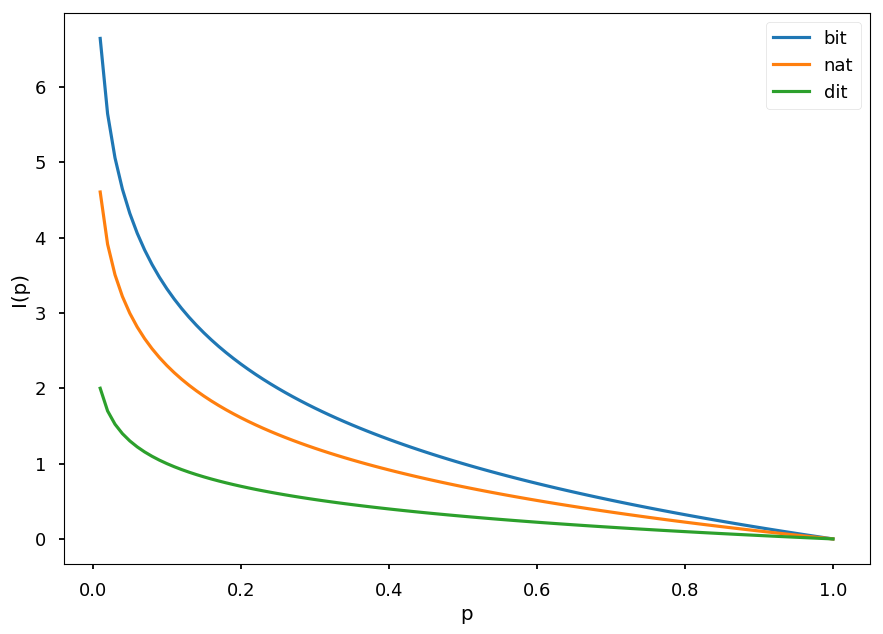

In [0]:
x = np.arange(0.01, 1.01, 0.01)

plt.xlabel("p")
plt.ylabel("I(p)")

plt.plot(x, -np.log2(x), label="bit")
plt.plot(x, -np.log(x), label="nat")
plt.plot(x, -np.log10(x), label="dit")

plt.legend();

* Lets X = (head, tail) with P = (0.5, 0.5)

    * We get 1 Sh of information

* Lets X = (sunny, overcast, rainy) with P = (0.25, 0.75, 0.25)

    * If it is overcast, we get 0.415 Sh of information
    
    * Otherwise, we get 2 Sh of information
    
* If an event is more likely we learn less

#### Information entropy

* Also called Shannon entropy (after the father of intromation theory)

* Usually information entropy is denoted as $H$

* $H$ is defined as the weighted average of the self-information of all possible outcomes <p align="center"><br>$H(X) = \sum\limits_{i=1}^N p_i \cdot I(p_i) = -\sum\limits_{i=1}^N p_i\cdot\log(p_i)$</p><br>

* Lets consider two case scenario with $P = (p, 1 - p)$, so entropy is given by $H = -p \log(p) - (1 - p) \log(1 - p)$

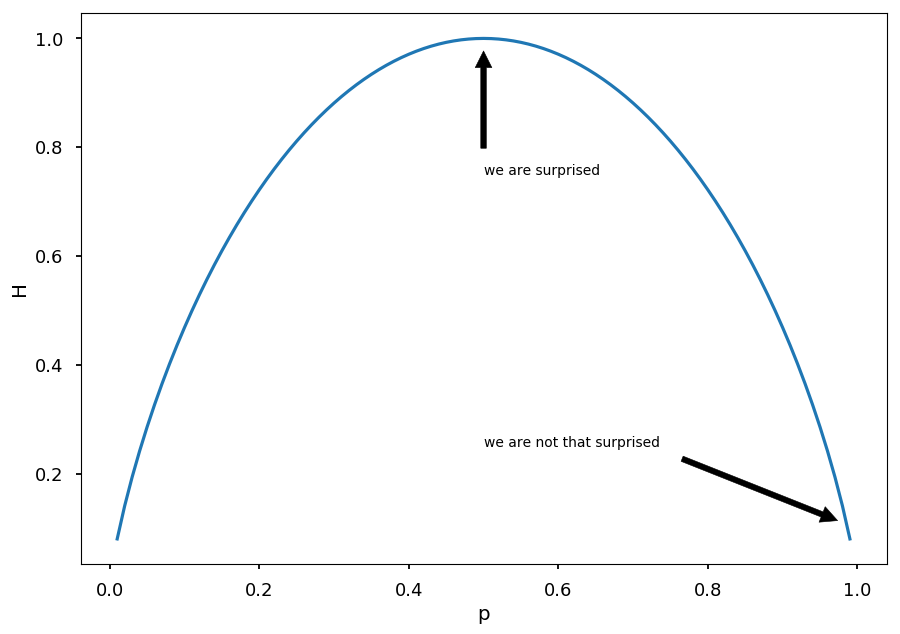

In [0]:
p = np.arange(0.01, 1.0, 0.01)

plt.xlabel("p")
plt.ylabel("H")

plt.annotate('we are surprised', xy=(0.5, 1), xytext=(0.5, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.annotate('we are not that surprised', xy=(1, 0.1), xytext=(0.5, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.plot(p, -p * np.log2(p) - (1 - p) * np.log2(1 - p));

* Lets consider three case scenario with $P = (p, q, 1 - p - q)$, so entropy is given by $H = -p \log(p) - q\log(q) - (1 - p - q) \log(1 - p - q)$

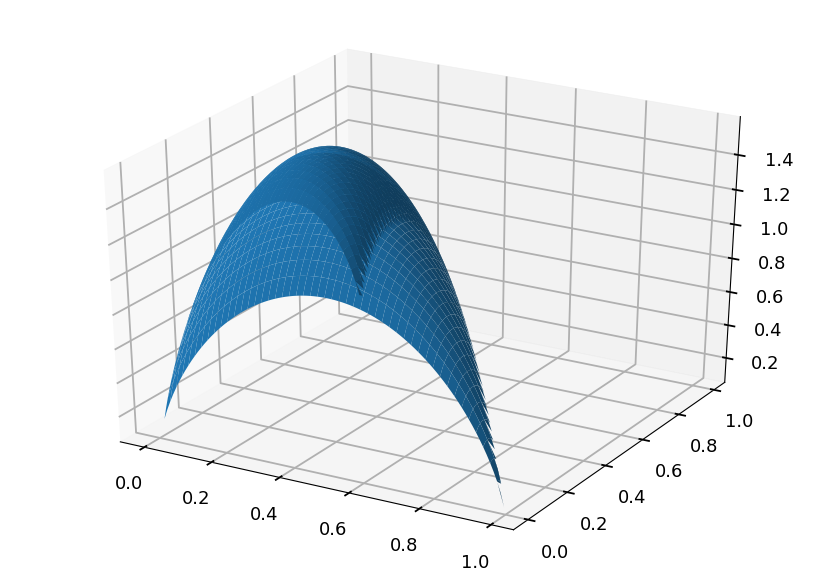

In [0]:
from mpl_toolkits import mplot3d

# grid of p, q probabilities
p, q = np.meshgrid(np.arange(0.01, 1.0, 0.01), np.arange(0.01, 1.0, 0.01))

# remove (set to 0) points which do not fulfill P <= 1
idx = p + q > 1
p[idx] = 0
q[idx] = 0

# calculate entropy (disable warnings - we are aware of log(0))
np.warnings.filterwarnings('ignore')
h = -p * np.log2(p) - q * np.log2(q) - (1 - p - q) * np.log2(1 - p - q)

# make a plot
plt.axes(projection='3d').plot_surface(p, q, h);

#### Information gain

* Let $T$ be the set of training samples with $n$ possible outcomes, thus $T = \{T_1, T_2, ..., T_n\}$

* The entropy is given by <p align="center"><br>$H(T) = -\sum\limits_{i=1}^N p_i\cdot\log(p_i) = -\sum\limits_{i=1}^N \frac{|T_i|}{|T|}\cdot\log(\frac{|T_i|}{|T|})$</p><br>
    
* We can also calulate the entropy after $T$ was partitioned in $T_i$ with respect to some feature $X$ <p align="center"><br>$H(T, X) = \sum\limits_{i=1}^N p_i\cdot H(T_i)$</p>

* And the information gain is defined as <p align="center"><br>$G(X) = H(T) - H(T, X)$</p>

##### Example

* Lets calculate some example step by step

* Lets consider a fake dataset

    * two classes: C01, C02
    
    * three features: X1, X2, X3

```
   X1  ||  A  |  A  |  A  |  B  |  B  |  C  |  C  |  C  |  C  |
---------------------------------------------------------------
   X2  ||  0  |  0  |  1  |  1  |  0  |  1  |  1  |  1  |  0  |
---------------------------------------------------------------
   X3  || RED | GRN | GRN | BLU | RED | GRN | BLU | RED | GRN |
===============================================================
 Class || C01 | C01 | C02 | C02 | C02 | C02 | C01 | C01 | C02 |
```

In [0]:
from math import log

def entropy(*probs):
  """Calculate information entropy"""
  try:
    total = sum(probs)
    return sum([-p / total * log(p / total, 2) for p in probs])
  except:
    return 0

print(entropy(4, 5), entropy(2, 1), entropy(2, 2))

0.9910760598382222 0.9182958340544896 1.0


* The *root* entropy

    * We have 9 samples: 4 belong to class C01 and 5 to C02 <p align="center"><br>$H(T) = -\frac{4}{9}\log(\frac{4}{9}) - \frac{5}{9}\log(\frac{5}{9}) = 0.99$</p><br>
    
* Now lets consider feature X1, which splits data into subsets $T_1$, $T_2$, and $T_3$ (with X1 value A, B, and C, respectively)<br><br>

    * Within $T_1$ there are 3 samples: 2 from C01 and 1 from C02 <p align="center"><br>$H(T_1) = -\frac{2}{3}\log(\frac{2}{3}) - \frac{1}{3}\log(\frac{1}{3}) = 0.92$</p><br>
    
    * Within $T_2$ there are 2 samples: 0 from C01 and 2 from C02 <p align="center"><br>$H(T_2) = -\frac{2}{2}\log(\frac{2}{2}) - \frac{0}{2}\log(\frac{0}{2}) = 0.00$</p><br>
    
    * Within $T_3$ there are 4 samples: 2 from C01 and 2 from C02 <p align="center"><br>$H(T_3) = -\frac{2}{4}\log(\frac{2}{4}) - \frac{2}{4}\log(\frac{2}{4}) = 1.00$</p><br>
    
    * The resulting entropy is <p align="center"><br>$H(T, X1) = \frac{3}{9}\cdot H(T_1) + \frac{2}{9}\cdot H(T_2) + \frac{4}{9}\cdot H(T_3) = 0.75$</p><br>
    
    * Thus, infromation gain if the set is split according to X1 <p align="center"><br>$G(X1) = H(T) - H(T, X1) = 0.99 - 0.75 = 0.24 \mbox{ Sh }$</p><br>

### ID3 algorithm

* For every attribute (feature) calculate the entropy

* Split the training set using the one for which information gain is maximum

* Continue recursively on subsets using remaining features

### Play Golf dataset

* Popular dataset to explain decision trees

* 4 features:

    * **outlook**: *rainy, overcast, sunny*
    
    * **temperature**: *cool, mild, hot*
    
    * **humidity**: *normal, high*
    
    * **windy**: *false, true*
    
* Possible outcomes (play golf?):

    * **false**
    
    * **true**

In [0]:
import pandas as pd

# first row = headers
src = "http://chem-eng.utoronto.ca/~datamining/dmc/datasets/weather_nominal.csv"

golf_data = pd.read_csv(src)

In [0]:
golf_data

,Outlook,Temperature,Humidity,Windy,Play golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


#### Play golf entropy

In [0]:
entropy(9, 5)

0.9402859586706309

```
| Play golf |
=============
| yes | no  |  -> H(T) = 0.94
-------------
|  9  |  5  |
```

#### Play golf vs outlook

```
                   | Play golf |
                   =============
                   | yes | no  |
        ------------------------
        | sunny    |  3  |  2  |  5
outlook | overcast |  4  |  0  |  4
        | rainy    |  2  |  3  |  5
        ------------------------
                      9     5
```

In [0]:
entropy(3, 2), 0, entropy(2, 3)

(0.9709505944546686, 0, 0.9709505944546686)

<br>

<p align="center">
\begin{eqnarray}
   H(\mbox{sunny}) & = & 0.97 \\
   H(\mbox{rainy}) & = & 0.97 \\
H(\mbox{overcast}) & = & 0
\end{eqnarray}
</p>

<br>

---

<br>

<p align="center">
\begin{eqnarray}
H(T, \mbox{outlook}) & = & P(\mbox{sunny})\cdot H(\mbox{sunny}) + P(\mbox{overcast})\cdot H(\mbox{overcast}) + P(\mbox{rainy})\cdot H(\mbox{rainy}) \\
                     & = & \frac{5}{14}\cdot 0.97 + \frac{4}{14} \cdot 0 + \frac{5}{14}\cdot 0.97 = 0.69
\end{eqnarray}
</p>

<br>

---

<br>

<p align="center">
\begin{eqnarray}
G(\mbox{outlook}) & = & H(T) - H(T, \mbox{outlook}) = 0.94 - 0.69 = 0.25
\end{eqnarray}
</p>

<br>

#### Results for all features

```
                    | Play golf |                         | Play golf |
                    =============                         =============
                    | yes | no  |                         | yes | no  |
         ------------------------                 --------------------
         | sunny    |  3  |  2  |                 | hot   |  2  |  2  |
 outlook | overcast |  4  |  0  |     temperature | mild  |  4  |  2  |
         | rainy    |  2  |  3  |                 | cool  |  3  |  1  |
         ------------------------                 --------------------
            Info. gain = 0.25                       Info gain = 0.03


                    | Play golf |                         | Play golf |
                    =============                         =============
                    | yes | no  |                         | yes | no  |
         ------------------------                 --------------------
         | high     |  3  |  4  |                 | false |  6  |  2  |
humidity | normal   |  6  |  1  |           windy | true  |  3  |  3  |
         ------------------------                 --------------------
            Info. gain = 0.15                       Info gain = 0.05
            

```

#### Root of the tree

* Start building a tree with the feature with the largest information gain: **outlook**

* A branch with **entropy 0** is a leaf node: **overcast**

* Other branches must be spliited using other features 

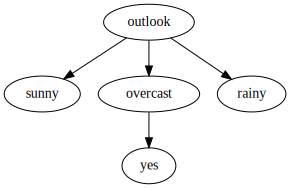

In [0]:
tree = Digraph()

tree.edge("outlook", "sunny")
tree.edge("outlook", "overcast")
tree.edge("outlook", "rainy")

tree.edge("overcast", "yes")

tree

#### Next branch

In [0]:
golf_data.loc[golf_data['Outlook'] == "Sunny"]

,Outlook,Temperature,Humidity,Windy,Play golf
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
9,Sunny,Mild,Normal,False,Yes
13,Sunny,Mild,High,True,No


* In general, one should calculate information gain for each feature for this subset

* In this case it is clear that we can take **windy** 

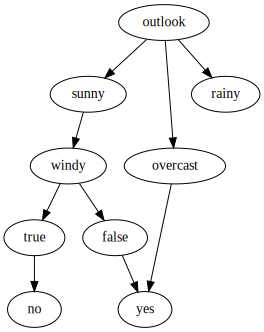

In [0]:
tree.edge("sunny", "windy")

tree.edge("windy", "false")
tree.edge("windy", "true")

tree.edge("false", "yes")
tree.edge("true", "no")

tree

#### Last branch

In [0]:
golf_data.loc[golf_data['Outlook'] == "Rainy"]

,Outlook,Temperature,Humidity,Windy,Play golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
10,Rainy,Mild,Normal,True,Yes


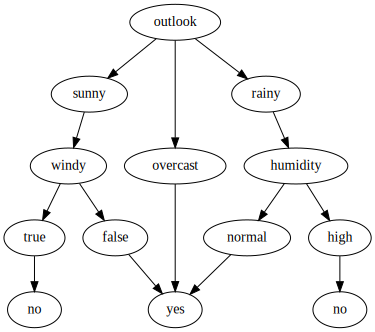

In [0]:
tree.edge("rainy", "humidity")

tree.edge("humidity", "high")
tree.edge("humidity", "normal")

tree.edge("normal", "yes")
tree.edge("high", "no ")

tree

#### Summary

* We got the final tree for Play Golf dataset using ID3 algorithm

* We do not even use temperature attribute (for which information gain was 0.03)

* The main problem is that the algorithm may overfit easily (tree does not stop growing until the whole training set is classified)

    * Imagine some crazy guys went playing on a **rainy**, **windy** day with **high humidity**, beacaue it was still **hot**
    
    * With this extra data point we would have to create more branches
    
    * Is one unique data sample worth to extend the whole tree?

* And there is more disadvantages:

    * It handles only discrete attributes

    * There is a strong bias for features with many possible outcomes

    * And finally, it does not handle missing values

### C4.5 algorithm

* C4.5 introduces some improvements to ID3:

    * continuous values using threshold
    
    * tree pruning to avoid overfitting
    
    * normalized information gain
    
    * missing values


#### Information gain ratio

* To avoid a bias in favor of features with a lot of different values C4.5 uses information gain ratio instead of information gain

* Lets define intrinsic value $V$ of an attribute $X$ as <p align="center">$V(X) = -\sum\limits_{i=1}^N \frac{|T_i|}{|T|}\cdot\log(\frac{|T_i|}{|T|})$</p>

* where $T_i$ are samples corresponding to $i$-th possible value of $X$ feature

* Information gain ratio $R(X)$ is defined as <p align="center">$R(X) = \frac{G(X)}{V(X)}$</p>

##### Example

* Lets consider a fake data set

* The goal is to determine if someone plays or not video games

* We have three features:

    * name - mostly unique
    
    * sex - 50% females and 50% males 
    
    * age - just old or young
    
* Looking at data we can say that

    * most young people play video games, why old people don't
    
    * sex does not matter
    
    * names are almost distinct

```
     name   ||  John  |  Mark  |  Anne  |  Adam  |  John  |  Alex  |  Alex  |  Xena  |  Tina  |  Lucy  |
--------------------------------------------------------------------------------------------------------
     sex    ||   M    |   M    |   F    |   M    |   M    |   F    |   M    |   F    |   F    |   F    |
--------------------------------------------------------------------------------------------------------
     age    ||  old   | young  |  old   | young  | young  | young  |  old   |  old   | young  | young  |
========================================================================================================
 play games ||   N    |   Y    |   Y    |   Y    |   Y    |   N    |   N    |   N    |   Y    |   Y    |
```

* Information gain for **name**

In [0]:
h = entropy(4, 6)  # dataset entropy H(T)

# one John plays and the other one doesn't
# in other cases entropy = 0
g_name = h - 2/10 * entropy(1, 1)

print(g_name)

0.7709505944546686


* Information gain for **sex**

In [0]:
# 5 men - 3 play
# 5 women - 3 play
g_sex = h - 5/10 * entropy(2, 3) - 5/10 * entropy(2, 3)

print(g_sex)

0.0


* Information gain for **age**

In [0]:
# 4 old people - 1 plays
# 6 young people - 5 play
g_age = h - 4/10 * entropy(1, 3) - 6/10 * entropy(1, 5)

print(g_age)

0.256425891682003


* In ID3 a feature with entropy = 0 is always a winner

    * Imagine having all distinct values (e.g. credit card numbers)

* In this case we would choose **name** as the best predictor

    * Creating a tree with 8 branches (from 10 samples)

    * Training data would be perfectly classify

    * But it is unlikely that the algorithm would be able to generalize for unseen data

* Lets calculate information gain ratio and see how it changes the choice of the best feature

* Information gain ratio for **name**

In [0]:
# 2x John, 2x Alex, 6x unique name 
g_name / entropy(2, 2, *[1]*6)

0.26384995435159336

* Information gain ratio for **sex**

In [0]:
# 5 males and 5 females - zero stays zero though
g_sex / entropy(5, 5)

0.0

* Information gain ratio for **age**

In [0]:
# 4x old and 6x young
g_age / entropy(4, 6)

0.26409777505314147

* Based on information gain ratio we choose **age** as the best predictor

* Because the denominator in a ratio penalizes features with many values

In [0]:
print("Two possible values:\n")

for i in range(0, 11):
  print("\t({}, {}) split -> entropy = {}".format(i, 10-i, entropy(i, 10-i)))

print("\n10 possible values:", entropy(*[1]*10))


Two possible values:

	(0, 10) split -> entropy = 0
	(1, 9) split -> entropy = 0.4689955935892812
	(2, 8) split -> entropy = 0.7219280948873623
	(3, 7) split -> entropy = 0.8812908992306927
	(4, 6) split -> entropy = 0.9709505944546686
	(5, 5) split -> entropy = 1.0
	(6, 4) split -> entropy = 0.9709505944546686
	(7, 3) split -> entropy = 0.8812908992306927
	(8, 2) split -> entropy = 0.7219280948873623
	(9, 1) split -> entropy = 0.4689955935892812
	(10, 0) split -> entropy = 0

10 possible values: 3.321928094887362


* This datset was handcrafted to make a point, but I hope the message is still clear

#### Continuous values

* Attributes with continuous values must be first discretize

* The best way is to find an optimal threshold which splits the set

* The optimal threshold is the one which maximize the infromation gain

##### Example

* Lets consider the same example as before

* But this time age has numerical values

```
     name   ||  John  |  Mark  |  Anne  |  Adam  |  John  |  Alex  |  Alex  |  Xena  |  Tina  |  Lucy  |
--------------------------------------------------------------------------------------------------------
     sex    ||   M    |   M    |   F    |   M    |   M    |   F    |   M    |   F    |   F    |   F    |
--------------------------------------------------------------------------------------------------------
     age    ||   50   |   18   |   65   |   24   |   31   |   18   |   50   |   50   |   24   |   31   |
========================================================================================================
 play games ||   N    |   Y    |   Y    |   Y    |   Y    |   N    |   N    |   N    |   Y    |   Y    |
```

* The possible thesholds are therefore $\{18, 24, 31, 50\}$

In [0]:
# calculate entropy for all possible thresholds
e18 = 2/10 * entropy(1, 1) + 8/10 * entropy(3, 5)
e24 = 4/10 * entropy(1, 3) + 6/10 * entropy(3, 3)
e31 = 6/10 * entropy(1, 5) + 4/10 * entropy(3, 1)
e50 = 9/10 * entropy(4, 5) + 1/10 * entropy(0, 1)

print("With threshold = {}, entropy = {}".format(18, e18))
print("With threshold = {}, entropy = {}".format(24, e24))
print("With threshold = {}, entropy = {}".format(31, e31))
print("With threshold = {}, entropy = {}".format(50, e50))

With threshold = 18, entropy = 0.963547202339972
With threshold = 24, entropy = 0.9245112497836532
With threshold = 31, entropy = 0.7145247027726656
With threshold = 50, entropy = 0.8919684538544


* The best test is `if age > 31`

    * it splits the dataset to 6 samples (with 5 players) and 4 samples (with 3 non-players)
    
* Please note, that the best threshold may change once a node is created

#### Unknown parameters

* In the case some samples are incomplete one needs to correct the information gain

* The information gain is calculated as before for samples with known attributes

* But then it is normalized with respect to the probability that the given attribute has known values

* Lets define the factor $F$ as the ratio of the number of samples with known value for a given feature to the number of all samples in a dataset

* Then information gain is defines as <p align="center">$G(X) = F\cdot (H(T) - H(T, X))$</p>

* Please note, that $F = 1$ if all values are known

* Otherwise, information gain is scaled accordingly

#### Pruning

* The algorithm creates as many nodes as needed to classify all test samples

* It may lead to overfitting and the resulting tree would fail to classify correctly unseen samples

* To avoid this one can prune a tree

    * pre-pruning (early stopping)
    
        * stop building a tree before leaves with few samples are produced
        
        * how to decide when it is good time to stop? e.g. using cross-validation on validation set (stop if the error does not increase significantly)
        
        * underfitting if stop to early
        
    * post-pruning
    
        * let a tree grow completely
        
        * then go from bottom to top and try to replace a node with a leaf
        
        * if there is improvement in accuracy - cut a tree
        
        * if the accuracy stays the same - cut a tree (Occam's razor)
        
        * otherwise leave a node   
      

### First example - step by step

* Lets consider the problem from the beginning of the lecture

* Our dataset has 20 blue points and 20 orange points

* Each point has two features (both are numerical)

* We expect overfitting if pruning is not applied

* We will calculate everything step by step (it is boring, but demonstrates how the algorithm works)

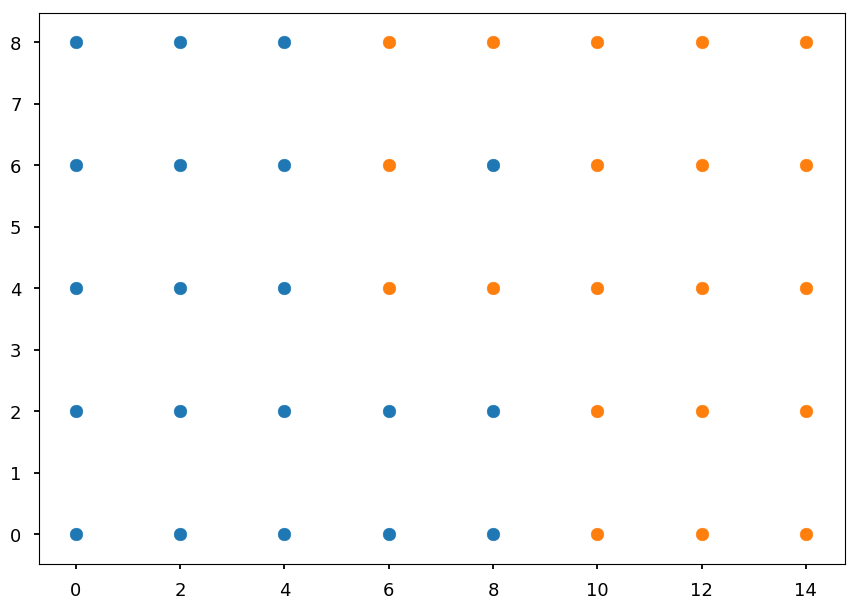

In [0]:
# first define some points representing two classes
grid = np.mgrid[0:10:2, 0:10:2]
set01 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set01 = np.delete(set01, [17, 18, 19, 22, 24], axis=0)

grid = np.mgrid[6:16:2, 0:10:2]
set02 = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
set02 = np.delete(set02, [0, 1, 5, 6, 8], axis=0)

plt.scatter(*set01.T)
plt.scatter(*set02.T);

#### Validation set

* We will use 10 points from the dataset for validation

* This time selected manually to perform by hand calculations

* On the plot below X denotes validation samples

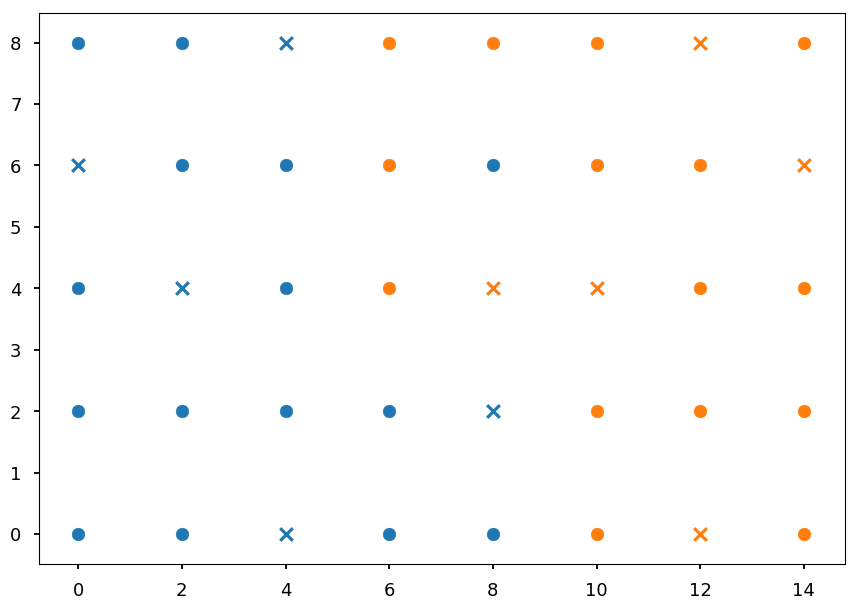

In [0]:
# split dataset to training and validation set
# note, we should splt them randomly
# but here we do this by hand
valid_idx = [3, 7, 10, 14, 18]

blue_valid = set01[valid_idx]
blue_train = np.delete(set01, valid_idx, axis=0)

orange_valid = set02[valid_idx]
orange_train = np.delete(set02, valid_idx, axis=0)

# circles - training set
# x - validation set
plt.scatter(*blue_train.T)
plt.scatter(*blue_valid.T, color='C0', marker='x')
plt.scatter(*orange_train.T)
plt.scatter(*orange_valid.T, color='C1', marker='x');

#### Thresholds finder

* When building a tree we need to calculate information gain for every threshold in current subset

* Every subset $S$ has $N_b$ blue samples and $N_o$ orange samples

* After split into accoring to some threshold we get two subsets

    * $n_b$ of blue points and $n_o$ of orange points ($S_1$)
    
    * $N_b - n_b$ of blue points and $N_o - n_o$ of orange points ($S_2$)
    


In [0]:
def info_gain(Nb, No, nb, no):
  """Calculate information gain for given split"""
  h = entropy(Nb, No) # H(S)
  total = Nb + No     # total number of samples
  subtotal = nb + no  # number of samples in subset
  
  return h - subtotal / total * entropy(nb, no) \
           - (total - subtotal) / total * entropy(Nb - nb, No - no)

#### Feature X

* We need to calculate information gain ratio for the best threshold (the one that maximize information gain)

* Possible thresholds $\{0, 2, 4, 6, 8, 10, 12\}$

In [0]:
Nb = 15
No = 15

splits = {"0": (4, 0), "2 ": (8, 0), "4": (11, 0), "6": (13, 3),
          "8": (15, 4), "10": (15, 8), "12": (15, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.14818913558232172
Threshold = 2 	 -> 0.33824492595034883
Threshold = 4	 -> 0.5297578726233217
Threshold = 6	 -> 0.3525728312615027
Threshold = 8	 -> 0.5297578726233217
Threshold = 10	 -> 0.28538113149388267
Threshold = 12	 -> 0.14818913558232172


* We got the same cuts as predicted at the beginning of the lecture: $x > 4$ or $x > 8$

* Lets choose $x > 4$ and calculate information gain ratio

In [0]:
# 4 samples with x = 0, 4 samples with x = 2 etc
info_gain(Nb, No, *splits["4"]) / entropy(4, 4, 3, 5, 3, 4, 3, 4)

0.1779055922617179

#### Feature Y

* Repeat the procedure

* This time possible thresholds = $\{0, 2, 4, 6\}$

In [0]:
Nb = 15
No = 15

splits = {"0": (4, 2), "2": (8, 5), "4": (10, 8), "6": (13, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.02035297064032593
Threshold = 2	 -> 0.029594041354123246
Threshold = 4	 -> 0.013406861436605633
Threshold = 6	 -> 0.0203529706403259


* The best cut is $y > 2$ (as predicted before)

* Lets calculate information gain ratio

In [0]:
info_gain(Nb, No, *splits["2"]) / entropy(6, 7, 5, 6, 6)

0.01278981522839263

#### The root

* At the beginning we discussed the choice of $y$ as a root predictor

* ID3 and C4.5 are greedy algorithms and select optimal solution at given stage

* We can start to build the tree with the first best predictor

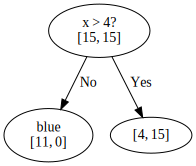

In [0]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "[4, 15]", "Yes")

tree

#### Branch x > 4

* Now we have to repeat the procedure for the branch $[4, 15]$

* Lets take a look what points are left

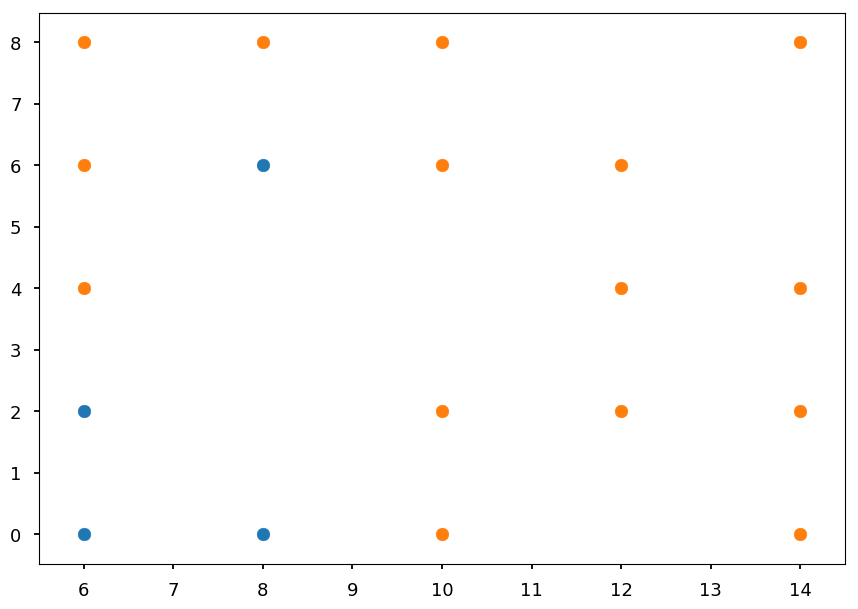

In [0]:
plt.xlim([5.5, 14.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

* Check $x$ maximum information gain ratio

In [0]:
Nb = 4
No = 15

splits = {"6": (2, 3), "8": (4, 4), "10": (4, 8), "12": (4, 11)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 6	 -> 0.051004839414443226
Threshold = 8	 -> 0.32143493796317624
Threshold = 10	 -> 0.16251125329718286
Threshold = 12	 -> 0.08198172064120202


In [0]:
print("Information gain ratio with x > 8:",
      info_gain(Nb, No, *splits["8"]) / entropy(5, 3, 4, 3, 4))

Information gain ratio with x > 8: 0.14010311259651076


* Check $y$ maximum information gain ratio

In [0]:
Nb = 4
No = 15

splits = {"0": (2, 2), "2": (3, 5), "4": (3, 6), "6": (4, 9)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.08471690647404045
Threshold = 2	 -> 0.08617499693494635
Threshold = 4	 -> 0.06066554625879636
Threshold = 6	 -> 0.13320381570773476


In [0]:
print("Information gain ratio with y > 6:",
      info_gain(Nb, No, *splits["6"]) / entropy(4, 4, 3, 4, 4))

Information gain ratio with y > 6: 0.05757775370755489


* Once again $x$ is a winner

* And we have a new node

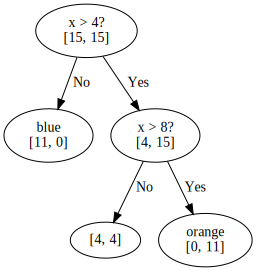

In [0]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree

#### Branch x<= 8

* We will continue until the tree is fully grown

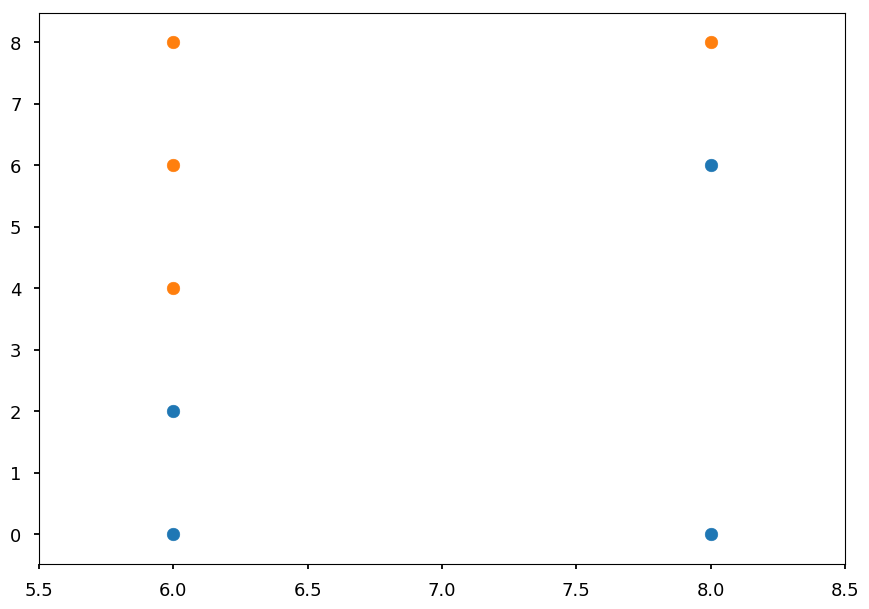

In [0]:
plt.xlim([5.5, 8.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

* Again, the best cut may be pretty obvious, but lets check the math
* We have one possible cut in $x$

In [0]:
Nb = 4
No = 4

print("Information gain ratio with x > 6:",
      info_gain(Nb, No, 2, 3) / entropy(5, 3))

Information gain ratio with x > 6: 0.05112447853477686


* And usual threshold candidates in $y$

In [0]:
splits = {"0": (2, 0), "2": (3, 0), "4": (3, 1), "6": (4, 2)}

for threshold, (no, nb) in splits.items():
  print("Threshold = {}\t -> {}".format(threshold, info_gain(Nb, No, no, nb)))

Threshold = 0	 -> 0.31127812445913283
Threshold = 2	 -> 0.5487949406953986
Threshold = 4	 -> 0.1887218755408671
Threshold = 6	 -> 0.31127812445913283


In [0]:
print("Information gain ratio with y > 2:",
      info_gain(Nb, No, *splits["2"]) / entropy(2, 1, 1, 2, 2))

Information gain ratio with y > 2: 0.24390886253128827


* And the tree is growing

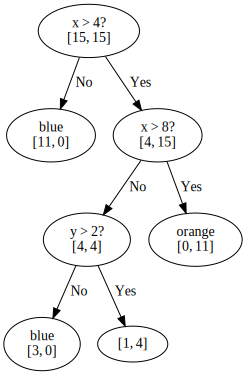

In [0]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "[1, 4]", "Yes")

tree

#### Branch y > 2

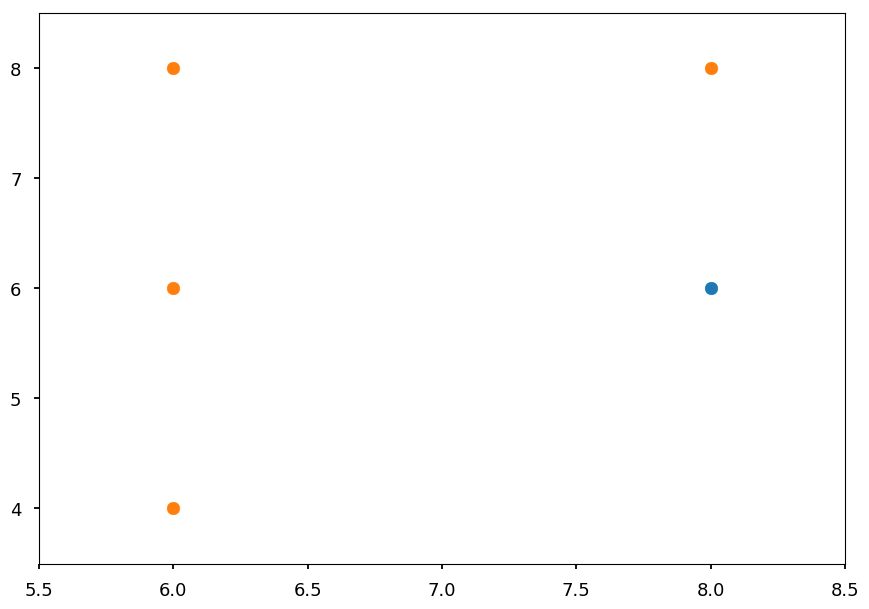

In [0]:
plt.xlim([5.5, 8.5])
plt.ylim([3.5, 8.5])

plt.scatter(*blue_train.T)
plt.scatter(*orange_train.T);

In [0]:
Nb = 1
No = 4

print("Information gain ratio with x > 6:",
      info_gain(Nb, No, 0, 3) / entropy(3, 2))

Information gain ratio with x > 6: 0.33155970728682876


In [0]:
print("Information gain ratio with y > 4:",
      info_gain(Nb, No, 0, 1) / entropy(1, 2, 2))

print("Information gain ratio with y > 6:",
      info_gain(Nb, No, 1, 2) / entropy(1, 2, 2))

Information gain ratio with y > 4: 0.047903442721748145
Information gain ratio with y > 6: 0.11232501392736344


#### The final tree

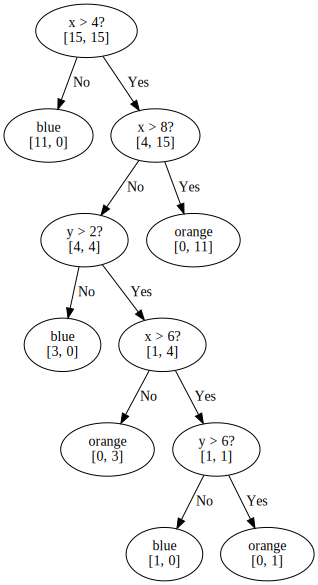

In [0]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "x > 6?\n[1, 4]", "Yes")

tree.edge("x > 6?\n[1, 4]", "orange\n[0, 3]", "No")
tree.edge("x > 6?\n[1, 4]", "y > 6?\n[1, 1]", "Yes")

tree.edge("y > 6?\n[1, 1]", "blue\n[1, 0]", "No")
tree.edge("y > 6?\n[1, 1]", "orange\n[0, 1]", "Yes")

tree

* It is likely that this tree is overfitted

* We will proceed with pruning as it was explained

* But first lets implement decision rules to measure accuracy

In [0]:
def tree_nominal(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  elif x <= 6:
    return "orange"
  else:
    return "orange" if y > 6 else "blue"

#### Sanity check

* If the tree is built *correctly* we expect 100% accuracy on training set

In [0]:
for x, y in blue_train:
  print(tree_nominal(x, y), end=' ')

blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue 

In [0]:
for x, y in orange_train:
  print(tree_nominal(x, y), end=' ') 

orange orange orange orange orange orange orange orange orange orange orange orange orange orange orange 

#### Accuracy before pruning

In [0]:
def accuracy(samples, tree):
  """Just print the result of classification"""
  for x, y in samples:
    print("({}, {}) -> {}".format(x, y, tree(x, y)))

In [0]:
accuracy(blue_valid, tree_nominal)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [0]:
accuracy(orange_valid, tree)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


#### Pruning I

* We want to prune last decision node $y > 6$

* In general, majority decides about the leaf node class

* As it is a tie here, lets check both

In [0]:
def tree_prune01a(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  elif x <= 6:
    return "orange"
  else:
    return "blue"
  
def tree_prune01b(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  elif y <= 2:
    return "blue"
  else:
    return "orange"

In [0]:
accuracy(blue_valid, tree_prune01a)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [0]:
accuracy(orange_valid, tree_prune01a)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* Pruning does not change the accuracy

* We always use Occam's razor and `prune01a` is preferred over nominal tree

* But lets see how `prune01b` works

In [0]:
accuracy(blue_valid, tree_prune01b)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [0]:
accuracy(orange_valid, tree_prune01b)

(8, 4) -> orange
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* In this case we even get the increase of the accuracy

* We decide to prune a tree by replacing $y > 6$ decision node with "orange" leaf node

* Which automatically removes $x > 6$ decision node

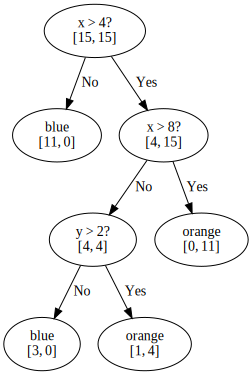

In [0]:
tree = Digraph()

tree.edge("x > 4?\n[15, 15]", "blue\n[11, 0]", "No")
tree.edge("x > 4?\n[15, 15]", "x > 8?\n[4, 15]", "Yes")

tree.edge("x > 8?\n[4, 15]", "y > 2?\n[4, 4]", "No")
tree.edge("x > 8?\n[4, 15]", "orange\n[0, 11]", "Yes")

tree.edge("y > 2?\n[4, 4]", "blue\n[3, 0]", "No")
tree.edge("y > 2?\n[4, 4]", "orange\n[1, 4]", "Yes")

tree

#### Pruning II

* Now, lets see the accuracy after removing $y > 2$ node

* It is once again a tie, so lets check both scenarios

In [0]:
def tree_prune02a(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  else:
    return "orange"
  
def tree_prune02b(x, y):
  """Implementation of above tree"""
  if x <= 4:
    return "blue"
  elif x > 8:
    return "orange"
  else:
    return "blue"

In [0]:
accuracy(blue_valid, tree_prune02a)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> orange


In [0]:
accuracy(orange_valid, tree_prune02a)

(8, 4) -> orange
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


In [0]:
accuracy(blue_valid, tree_prune02b)

(0, 6) -> blue
(2, 4) -> blue
(4, 0) -> blue
(4, 8) -> blue
(8, 2) -> blue


In [0]:
accuracy(orange_valid, tree_prune02b)

(8, 4) -> blue
(10, 4) -> orange
(12, 0) -> orange
(12, 8) -> orange
(14, 6) -> orange


* In both cases the error increased

* We stop pruning and leave the tree as it is in `prune01b` version 

#### Summary

* C4.5 algorithm gives the full and clear prescription for building decision trees

* It may look as a long procedure, but it is only because I wanted to show everything step by step and avoid *"after a few trivial steps..."*

* ID3/C4.5/C5.0 are based on information theory

* There is alternative procedure based on *gini impurity*, which is used by CART

## CART

* CART stands for Classification and Regression Tree

* It was created independently from ID3 (more or less at the same time)

* The main differences:

    * it creates binary trees (each decision node has two branches)
    
    * it uses gini impurity instead of information gain
    
    * it supports numerical target variables (regression)

### Gini impurity

* Let $T = \{T_1, T_2, ..., T_n\}$ be the set of $n$ classes

* and $P = \{p_1, p_2, ..., p_n\}$ be the probability distribution

* where $p_i$ is the probability that a sample belongs to class $T_i$

* and $1 - p_i$ is the probability that it belongs to another class

* Gini impurity is defines as <p align="center">$I(P) = \sum\limits_{i=1}^n p_i\cdot (1 - p_i) = \sum\limits_{i=1}^n p_i - \sum\limits_{i=1}^n p_i^2 = 1 - \sum\limits_{i=1}^n p_i^2$</p>

* As before (for entropy), lets consider two case scenario with $P = (p, 1 - p)$, so gini impurity is given by $I = 1 - p^2 - (1 - p)^2 = -2p(p - 1)$

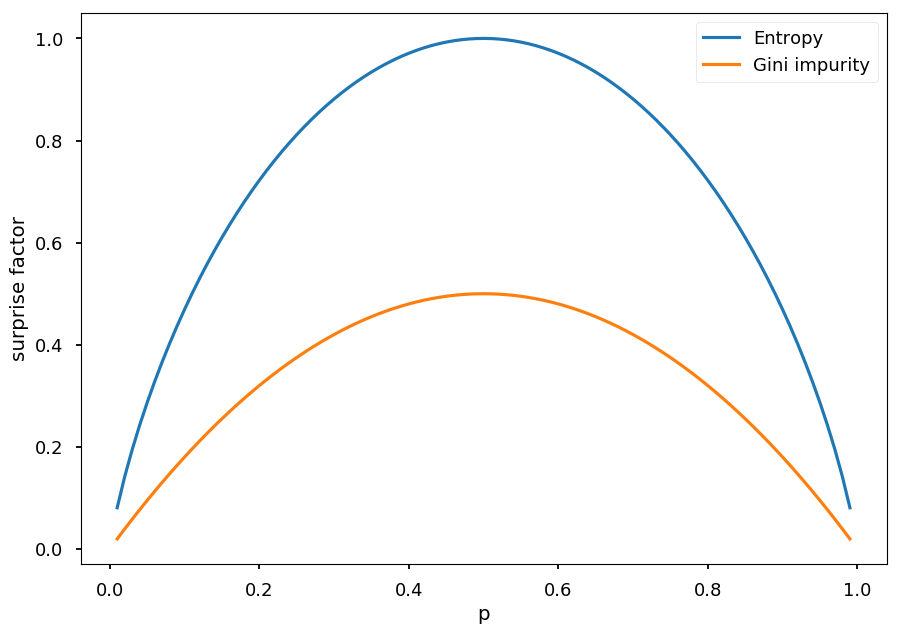

In [0]:
p = np.arange(0.01, 1.0, 0.01)

plt.xlabel("p")
plt.ylabel("surprise factor")

plt.plot(p, -p * np.log2(p) - (1 - p) * np.log2(1 - p), label="Entropy");
plt.plot(p, -2*p*(p - 1), label="Gini impurity")

plt.legend();

### Play Golf

* Lets consider once again Play Golf dataset

In [0]:
import pandas as pd

# first row = headers
src = "http://chem-eng.utoronto.ca/~datamining/dmc/datasets/weather_nominal.csv"

golf_data = pd.read_csv(src)

In [0]:
golf_data

,Outlook,Temperature,Humidity,Windy,Play golf
0,Rainy,Hot,High,False,No
1,Rainy,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Sunny,Mild,High,False,Yes
4,Sunny,Cool,Normal,False,Yes
5,Sunny,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Rainy,Mild,High,False,No
8,Rainy,Cool,Normal,False,Yes
9,Sunny,Mild,Normal,False,Yes


#### Gini impurity

* We treat all values as they are continues

* And consider all possible split

* Every split leads to two subsets $S_1$ and $S_2$

* And gini impurity for a set $S$ for given split is given by: <p align="center">$I(S) = \frac{|S_1|}{|S|}\cdot I(S_1) + \frac{|S_2|}{|S|}\cdot I(S_2)$</p>

In [0]:
def gini(*distribution):
  """Calculate gini impurity for given ditribution of samples"""
  sum2 = sum(distribution)**2  # normalization factor
  
  return 1 - sum([p**2 for p in distribution])/sum2

In [0]:
def gini_split(s1, s2, g1, g2):
  """Calcualte impurity for given split
  
  s1 -- the size of S1 subset
  s1 -- the size of S2 subset
  g1 -- I(S1)
  g2 -- I(S2)
  """
  s = s1 + s2  # the total set size
  
  return s1/s * g1 + s2/s * g2

```
            | Play golf |
            =============
            | yes | no  |
      -------------------
      | yes |  2  |  3  | 5
rainy | no  |  7  |  2  | 9
      -------------------
               9     5
```

In [0]:
gini_split(5, 9, gini(2, 3), gini(7, 2))

0.3936507936507937

```
            | Play golf |
            =============
            | yes | no  |
      -------------------
      | yes |  3  |  2  | 5
sunny | no  |  6  |  3  | 9
      -------------------
               9     5
```

In [0]:
gini_split(5, 9, gini(3, 2), gini(6, 3))

0.45714285714285713

```
               | Play golf |
               =============
               | yes | no  |
         -------------------
         | yes |  4  |  0  | 4
overcast | no  |  5  |  5  | 10
         -------------------
                  9     5
```

In [0]:
gini_split(4, 10, gini(4, 0), gini(5, 5))

0.35714285714285715

* From *Outlook* feature the best choice is *Overcast* as it minimizes impurity

* However, we would have to check other features and choose the best predictor from all possibilities

* We have one step by step example done though

* So lets use some tool

### Scikit learn

* One step by step example is behind us, so now lets use some tool


* CART is implemented in `scikit-learn`

* However, their implementation takes only numerical values

* So we will use `LabelDecoder` to convert all values to numbers

In [0]:
from sklearn.preprocessing import LabelEncoder

# pandas.DataFrame.apply applies a function to given axis (0 by default)
# LabelEncoder encodes class labels with values between 0 and n-1
golf_data_num = golf_data.apply(LabelEncoder().fit_transform)

In [0]:
golf_data_num

,Outlook,Temperature,Humidity,Windy,Play golf
0,1,1,0,0,0
1,1,1,0,1,0
2,0,1,0,0,1
3,2,2,0,0,1
4,2,0,1,0,1
5,2,0,1,1,0
6,0,0,1,1,1
7,1,2,0,0,0
8,1,0,1,0,1
9,2,2,1,0,1


* Now, lets splits our dataset to features and labels

In [0]:
# DataFrame.iloc makes an access thourgh indices
# we want all rows and first 4 columns for features
# and the last column for labels
data = np.array(golf_data_num.iloc[:, :4])
target = np.array(golf_data_num.iloc[:, 4])

* Once data is prepared, creating a tree is as easy as 2 + 2 -1

In [0]:
from sklearn import tree

golf_tree = tree.DecisionTreeClassifier()

golf_tree.fit(data, target);

* `sklearn.tree` supports drawing a tree using `graphviz`

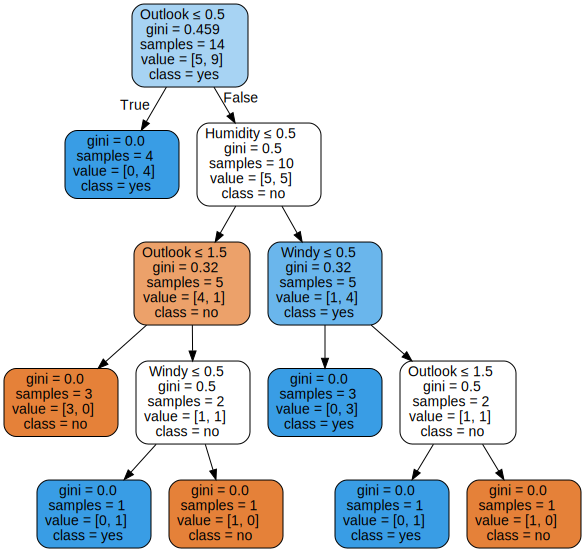

In [0]:
import graphviz

# dot is a graph description language
dot = tree.export_graphviz(golf_tree, out_file=None, 
                           feature_names=golf_data.columns.values[:4],  
                           class_names=["no", "yes"],  
                           filled=True, rounded=True,  
                           special_characters=True) 

# we create a graph from dot source using graphviz.Source
graph = graphviz.Source(dot) 
graph

* Please note, that in the case of a real problem we would want to have a validation set and perform a pruning (`scikit-learn` does not support it though)

### Regression

* The difference now is that targets are numerical values (instead of categorical), e.g. in golf data - number of hours played instead of "yes / no"

* Features may be either discrete or continuous

* The idea is the same though - we want to create a binary tree and minimize the error on in each leaf

* However, having continuous values as targets we can not simply use entropy or gini

* We need to use different measurement - variance <p align="center">$V(X) = \frac{1}{n}\sum\limits_{i=1}^n (x_i - \bar x)^2$</p>

* where $X = \{x_1, ..., x_n\}$ and $\bar x$ is the average value

* Note, that here $x_i$ are equally likely

#### Simple example

* Before we learn how to grow a regression tree, lets take a look how it works on a simple example

* Lets consider data distributed according to $x^2$ (with some noise, obviously)

* It means with have continuous features ($x$) and targets ($y$)

* We will split by hand the domain in $0.3$ and $0.6$

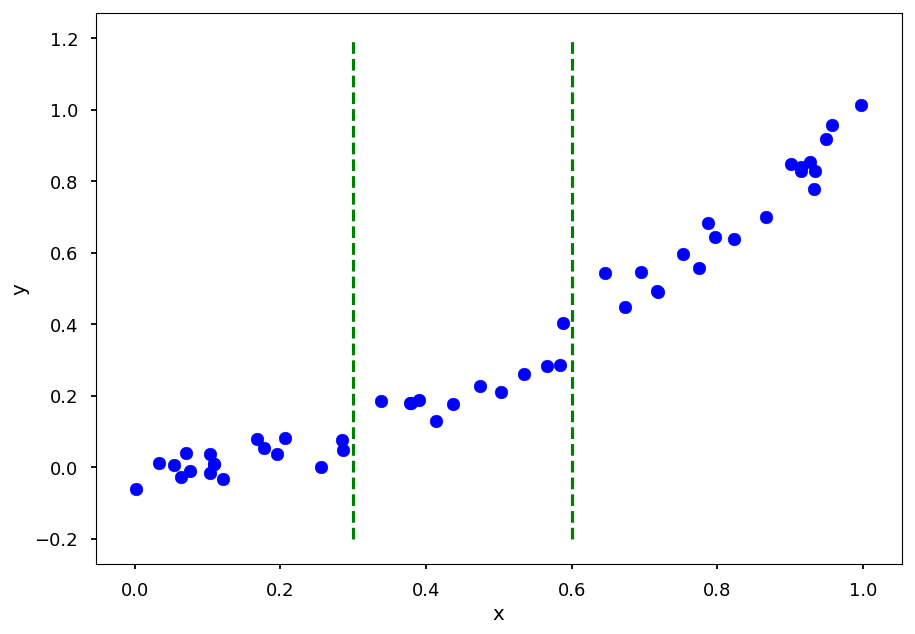

In [0]:
X = np.random.sample(50)
Y = np.array([x**2 + np.random.normal(0, 0.05) for x in X])

plt.xlabel("x")
plt.ylabel("y")

plt.scatter(X, Y, color='b')
plt.plot([0.3, 0.3], [-0.2, 1.2], 'g--')
plt.plot([0.6, 0.6], [-0.2, 1.2], 'g--');

* The corresponding tree would look like this

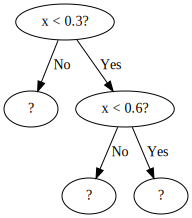

In [0]:
tree = Digraph()

tree.edge("x < 0.3?", "?", "No")
tree.edge("x < 0.3?", "x < 0.6?", "Yes")

tree.edge("x < 0.6?", "? ", "No")
tree.edge("x < 0.6?", "?  ", "Yes")

tree

* For each split lets find a value $\bar y$

In [0]:
def avg(X, Y, x_min, x_max):
  """Return the average value in (x_min, x_max) range"""
  n = 0    # number of samples in given split 
  avg = 0  # average value

  for x, y in zip(X, Y):
    if x >= x_min and x < x_max:
      n += 1
      avg += y

  return avg / n

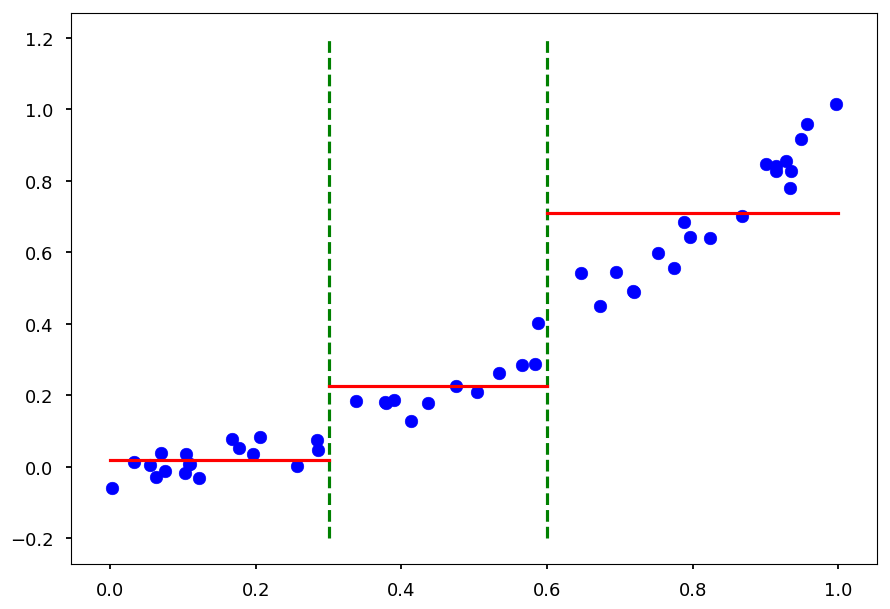

In [0]:
plt.scatter(X, Y, color='b')

plt.plot([0.3, 0.3], [-0.2, 1.2], 'g--')
plt.plot([0.6, 0.6], [-0.2, 1.2], 'g--')

y = avg(X, Y, 0, 0.3)
plt.plot([0.0, 0.3], [y, y], 'r')

y = avg(X, Y, 0.3, 0.6)
plt.plot([0.3, 0.6], [y, y], 'r')

y = avg(X, Y, 0.6, 1)
plt.plot([0.6, 1.0], [y, y], 'r');

* Alternatively, one could do linear regression for split

#### Growing a tree

* The idea is similar as for numerical values in classification problems

* For each feature we check all possible splits and calculate variance

* We choose a binary split which minimzes variance

In [0]:
from sklearn.tree import DecisionTreeRegressor

# create a decision tree regressor
fit = DecisionTreeRegressor()

# and grow it (note that X must be reshaped)
fit.fit(np.reshape(X, (-1, 1)), Y);

In [0]:
# prepare test sample with "newaxis" trick
X_test = np.arange(0.0, 1.0, 0.01)[:, np.newaxis]
Y_test = fit.predict(X_test)

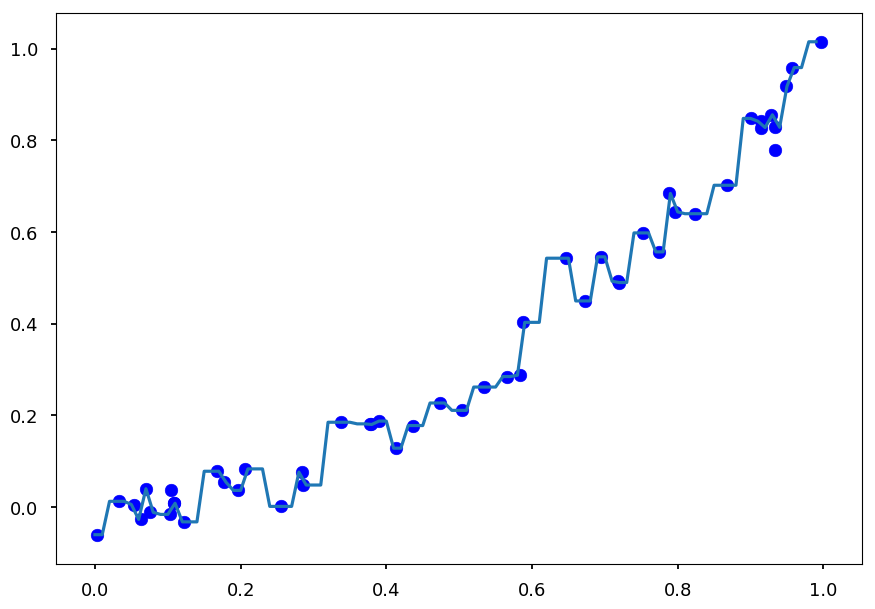

In [0]:
plt.scatter(X, Y, color='b')
plt.plot(X_test, Y_test);

* And this is a perfect example of **overfitting**

* Each point was *classified* as a separate target

* Beacause without any stopping criterion the tree is growing until there is a single point in a leaf

* There are several strategies to pre-prune a tree:

    * define a max depth of a tree
    
    * define a minimum number of samples in a leaf
    
    * define a minimum impurity
    
    * define a minimum impurity decrease
    
* Whatever method is chosen you get a hyperparameter

* And we already know how to find an optimal hyperparameter: cross-validation

### Tree: cross-validation

* To make it easier to check all possible methods lets create a simple class to do that for us

* It takes training data and hyperparameter name (as named in `scikit-learn`)

* It can change hyperparameter

* It can perform a cross-validation for a set of hyperparameter values

* It can make accuracy and best fit plots

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

class TreeCV:
  """Perform a cross-validation for chosen hyperparameter"""
  
  def __init__(self, X, Y, hp="max_depth"):
    """Save training data"""
    self.X = X    # features
    self.Y = Y    # targets
    self.hp = hp  # hyperparameter
    

  def set_method(self, hp):
    """Set hyperparameter to use"""
    self.hp = hp
    
  
  def cross_me(self, *hp_vals):
    """Perform cross validation for given hyperparameter values"""
    self.scores = []  # the accuracy table
    self.best = None  # the best fit
    
    best_score = 0
    
    for hp in hp_vals:
      # create a tree with given hyperparameter cut
      fit = DecisionTreeRegressor(**{self.hp: hp})
      
      # calculate a cross validation scores and a mean value
      score = cross_val_score(fit, np.reshape(X, (-1, 1)), Y).mean()
      
      # update best fit if necessary
      if score > best_score:
        self.best = fit
        best_score = score
      
      self.scores.append([hp, score])
    
    # train the best fit
    self.best.fit(np.reshape(X, (-1, 1)), Y)
      
      
  def plot(self):
    """Plot accuracy as a function of hyperparameter values and best fit"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
        
    plt.xlabel(self.hp)
    plt.ylabel("accuracy")

    plt.plot(*zip(*self.scores))

    plt.subplot(1, 2, 2)

    X_test = np.arange(0.0, 1.0, 0.01)[:, np.newaxis]
    Y_test = self.best.predict(X_test)

    plt.scatter(self.X, self.Y, color='b', marker='.', label="Training data")
    plt.plot(X_test, X_test * X_test, 'g', label="True distribution")    
    plt.plot(X_test, Y_test, 'r', label="Decision tree")

    plt.legend()

#### Traning dataset

In [0]:
X = np.random.sample(200)
Y = np.array([x**2 + np.random.normal(0, 0.05) for x in X])

#### `max_depth`

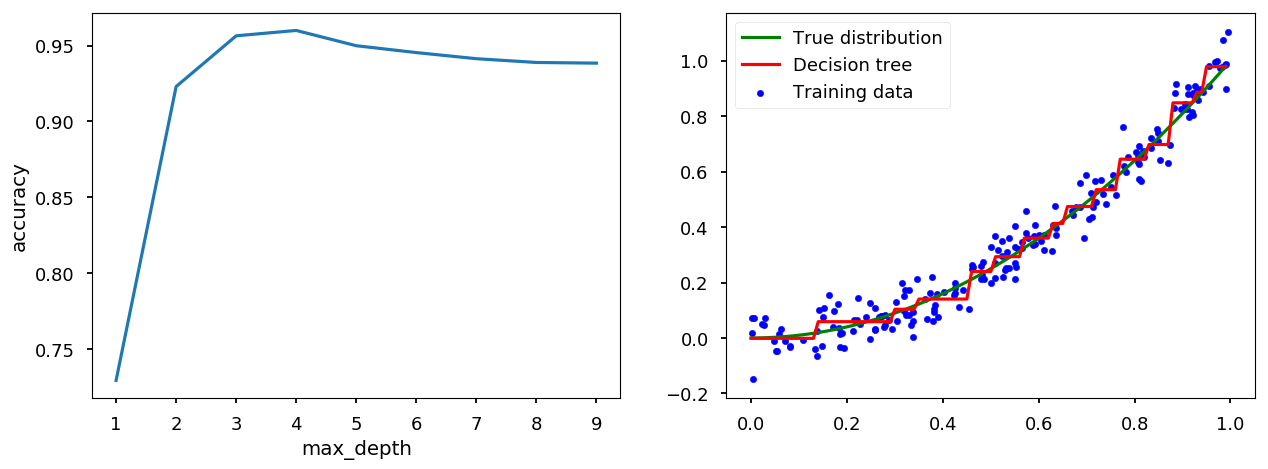

In [0]:
tree_handler = TreeCV(X, Y)
tree_handler.cross_me(*range(1, 10))
tree_handler.plot()

#### `min_samples_leaf`

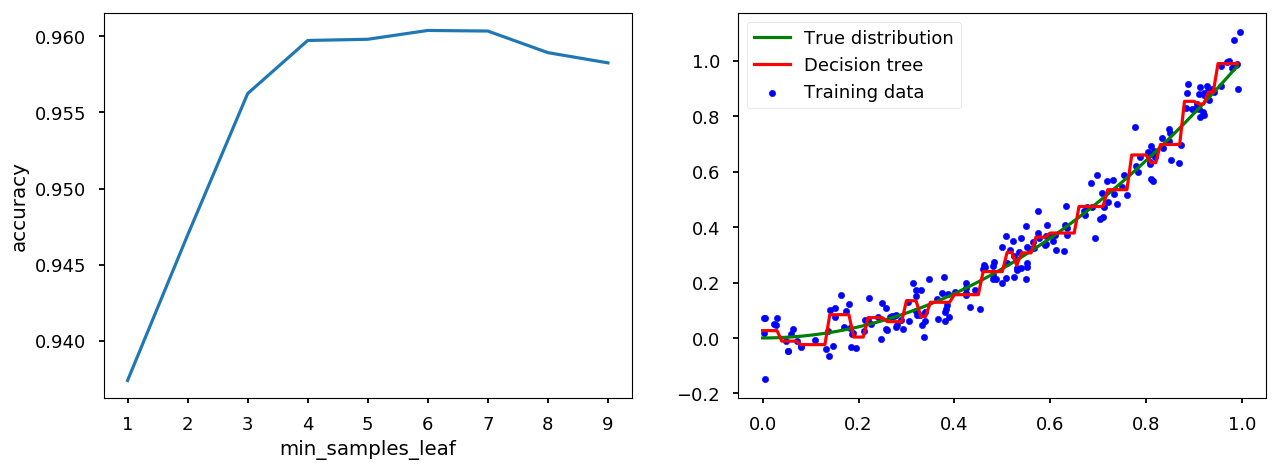

In [0]:
tree_handler.set_method("min_samples_leaf")
tree_handler.cross_me(*range(1, 10))
tree_handler.plot()

#### `min_impurity_split`

In [0]:
# min_impurity_split is depracated so lets disable warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

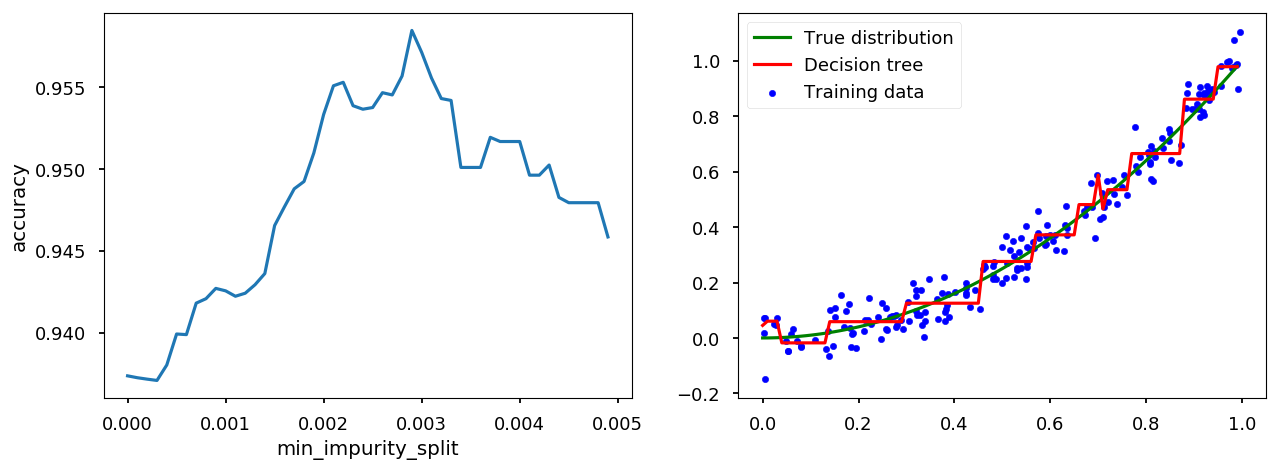

In [0]:
tree_handler.set_method("min_impurity_split")
tree_handler.cross_me(*np.arange(0.0, 5e-3, 1e-4))
tree_handler.plot()

#### `min_impurity_decrease`

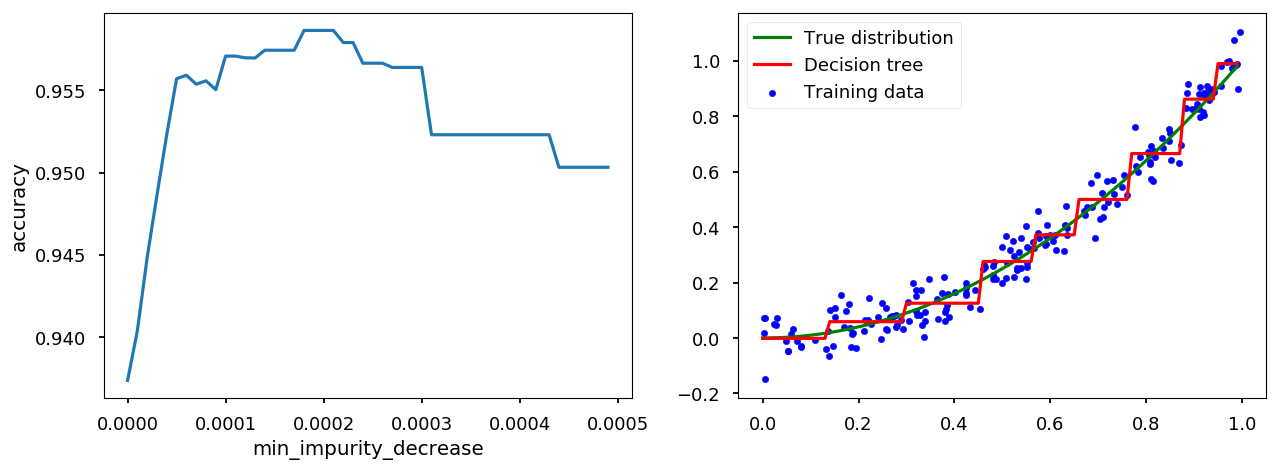

In [0]:
tree_handler.set_method("min_impurity_decrease")
tree_handler.cross_me(*np.arange(0.0, 5e-4, 1e-5))
tree_handler.plot()

## Bias-Variance trade-off

```
        +================+================+
       /\                |                /\
      /  \               |               /  \
     /    \              |              /    \
    /      \             |             /      \
   /        \            |            /        \
  / variance \           |           /   bias   \
  ^^^^^^^^^^^^           |           ^^^^^^^^^^^^
                         |
                         |
                         |
overfitting   <----------+--------->   underfitting

```

* Bias is an error coming from wrong model assumptions, which do not allow an algorithm to learn all patterns from training data.

* Variance is an error coming from sensivity to features specific for training data.

* High bias leads to underfitting and high variance to overfitting.

* Total error also depends on irreducible error (*noise* that can not be reduced by algorithm)

* Ultmiate goal is to minimize the total error

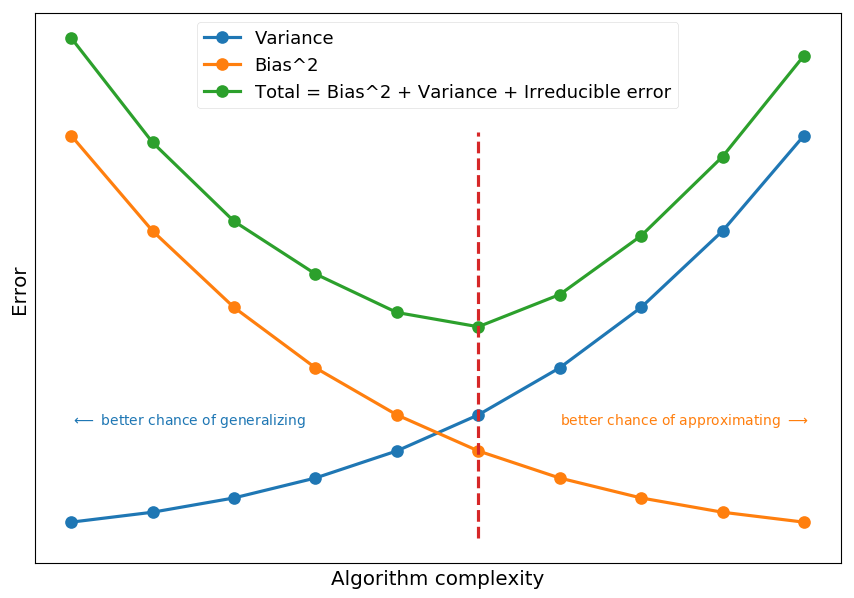

In [3]:
# fake bias, variance and noise
complexity = np.arange(1, 2, 0.1)
variance = np.power(complexity, 5)
bias2 = variance[::-1]
irreducible = [10*np.random.normal(abs(x - 1.5), 0.01) for x in complexity]

# total error = variance + bias^2 + irreducible
total = variance + bias2 + irreducible

plt.xticks([])
plt.yticks([])

plt.xlabel("Algorithm complexity")
plt.ylabel("Error")

plt.plot(complexity, variance, 'C0o-', label='Variance')
plt.plot(complexity, bias2, 'C1o-', label="Bias^2")
plt.plot(complexity, total, 'C2o-', label="Total = Bias^2 + Variance + Irreducible error")

plt.plot([1.5, 1.5], [0, 25], 'C3--')

plt.text(1.0, 7, "$\longleftarrow$ better chance of generalizing", color='C0')
plt.text(1.6, 7, "better chance of approximating $\longrightarrow$", color='C1')

plt.legend();

* Decision trees are sensitive to splits - small changes in training data may change a tree structure

    * deep trees tend to have high variance and low bias
    
    * shallow trees tend to have low variance and high bias

### Quick math

#### Basic

* The general goal of regression is to find how some dependent variable (target, $y$) is changing when independent variable (feature, $x$) varies

* Lets assume there is some *true* relationship describing this dependence $y = f(x)$

* We want to find $f(x)$ from observations of $(x, y)$ pairs

* Although, in real life we get some noisy observation, so $y = f(x) + \epsilon$

* As we do not know function $f(x)$ we want to approximate it with some other function $g(x)$ (estimator)

* In general, $g(x)$ is a parametrized model which can take many possible functional form

    * e.g. $g(x) = a\cdot x^2 + b\cdot x + c$ can take different coefficients (based on a training dataset)

#### Bias and variance

* Lets imagine there are $N$ possible training datasets $\{D_1, D_2, ..., D_N\}$

* For a given dataset one gets an estimators $g^{(D)}(x)$

* Lets denote the expected estimator by $\mathbf{E}_{D}\left[g^{(D)}(x)\right] \equiv \bar g(x)$

* If $N$ is large we can approximate it by an average over all datasets (law of large numbers) <p align="center"><br>$\bar g(x) \approx \frac{1}{N}\sum\limits_{i=1}^N g^{(D_i)}(x)$</p><br>

* The **variance** of an estimator tells us how far particular predictions are from the mean value <p align="center"><br>$var = \mathbf{E}_{D}\left[\left(g^{(D)}(x) - \bar g(x)\right)^2\right]$</p><br>

* Thus, if the training does not depend on the choice of a dataset the variance is low

* The **bias** of an estimator tells us how far the mean value is from the true value <p align="center"><br>$bias = \bar g(x) - f(x)$</p><br>

* Thus, if the model decribes data accurately the bias is low

* Please note the hidden assumption that all possible values of $x$ are equally likely

#### Goodness of a model

* The common practice to determine the goodness of a model fit is to calculate mean squared error

* The mean squared error is, well, the mean value of error squared: <p align="center"><br>$mse = \mathbf{E}_{x}\left[\mathbf{E}_{D}\left[\left(g^{(D)}(x) - y\right)^2\right]\right]$</p><br>

* Lets consider MSE for a particlar point $x$, $y = f(x) + \epsilon$, so <p align="center"><br>$mse = \mathbf{E}_{D}\left[\left(g^{(D)}(x) - y\right)^2\right] = \mathbf{E}_{D}\left[\left(g^{(D)}(x)\right)^2\right]- 2\cdot\mathbf{E}_{D}\left[g^{(D)}(x)\cdot y\right] + \mathbf{E}_{D}\left[y^2\right]$</p><br>

* Here, we used the linearity of the expected value operator. Lets use another common property: $\mathbf{E}\left[X^2\right] = \mathbf{E}\left[\left(X - \mathbf{E}\left[X\right]\right)^2\right] + \mathbf{E}\left[X\right]^2$ 

* So the first term can be rewritten in the form <p align="center"><br>$\mathbf{E}_{D}\left[\left(g^{(D)}(x)\right)^2\right] = \mathbf{E}_{D}\left[\left(g^{(D)}(x) - \mathbf{E}_{D}\left[g^{(D)}(x)\right]\right)^2\right] + \mathbf{E}_{D}\left[g^{(D)}(x)\right]^2 = \mathbf{E}_{D}\left[\left(g^{(D)}(x) - \bar g(x)\right)^2\right] + \left(\bar g(x)\right)^2$</p><br>

* And the last term <p align="center"><br>$\mathbf{E}_{D}\left[y^2\right] = \mathbf{E}_{D}\left[\left(y - \mathbf{E}_{D}\left[y\right]\right)^2\right] + \mathbf{E}_{D}\left[y\right]^2 = \mathbf{E}_{D}\left[\left(y - f(x)\right)^2\right] + \left(f(x)\right)^2$</p><br>

* Here, we used the fact that $\mathbf{E}_{D}\left[y\right] = f(x)$ (noise would average out when averaging over *infinite* number of datasets)

* For the middle term we use the fact that for independent $X$ and $Y$: $\mathbf{E}\left[XY\right] = \mathbf{E}\left[X\right]\cdot\mathbf{E}\left[Y\right]$, so $\mathbf{E}_{D}\left[g^{(D)}(x)\cdot y\right] = \bar g(x)\cdot f(x)$

* Taking all together we get <p align="center"><br>$mse = \underbrace{\mathbf{E}_{D}\left[\left(g^{(D)}(x) - \bar g(x)\right)^2\right]}_{variance} + \underbrace{\left(\bar g(x) - f(x)\right)^2}_{bias^2} + \underbrace{\mathbf{E}_{D}\left[\left(y - f(x)\right)^2\right]}_{noise}$</p><br>

### Example

* Lets consider $f(x) = \sin(\pi x)$

* With a noise given by a zero-mean Gaussian with a variance $\sigma^2$

* So the observation $y = f(x) + \mathcal{N}(0, \sigma^2)$

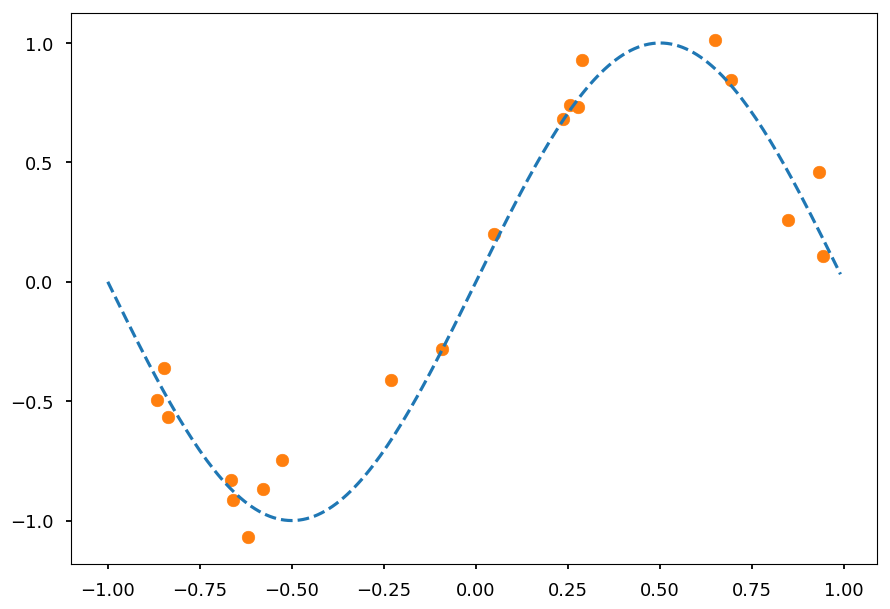

In [395]:
from math import sin, cos, pi, exp

def get_dataset(N=20, sigma=0.1):
  """Generate N training samples"""
  # X is a set of random points from [-1, 1]
  X = 2 * np.random.sample(N) - 1
  # Y are corresponding target values (with noise included)
  Y = np.array([sin(pi*x) + np.random.normal(0, sigma) for x in X])
  
  return X, Y

# plot a sample
X, Y = get_dataset()

x_ = np.arange(-1, 1, 0.01)

plt.scatter(X, Y, color='C1')
plt.plot(x_, np.sin(np.pi * x_), 'C0--');

* We do not know $f(x)$

* We assume it is a polynomial

* Lets consider polynomials of orders: $1 - 9$

    * $g_1(x) = a_1\cdot x + a_0$
    
    * $g_2(x) = a_2\cdot x^2 + \cdots + a_0$
    
    * $g_3(x) = a_3\cdot x^3 + \cdots + a_0$
    
    * ...
    
* Lets assume we have 100 independent dataset

* Each one has 20 points $(x, y = \sin(\pi x) + \mathcal{N}(0, \sigma^2))$

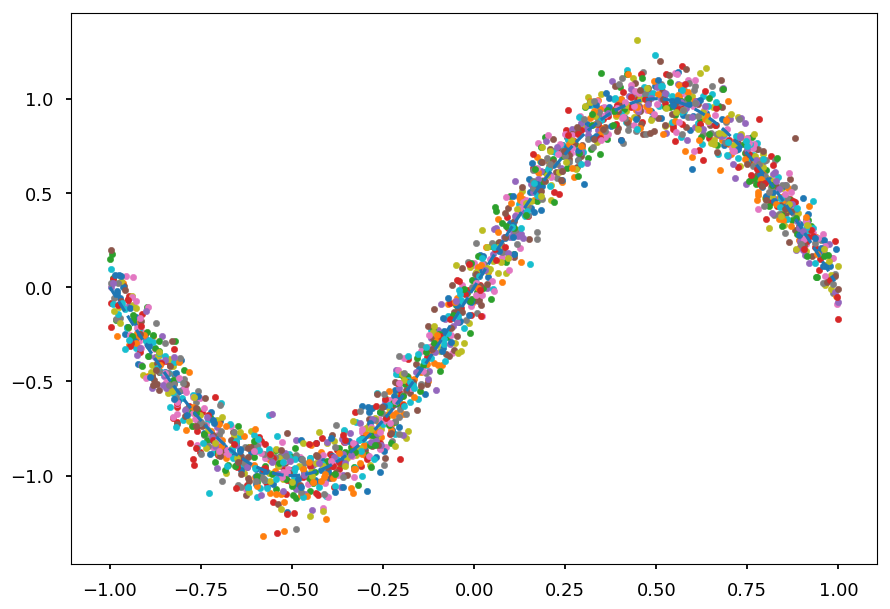

In [191]:
# generate 100 datasets with default settings
datasets = [get_dataset() for i in range(100)]

# and plot them all together with true signal
for i in range(100):
  plt.scatter(datasets[i][0], datasets[i][1], marker='.')

plt.plot(x_, np.sin(np.pi * x_), 'C0--');

* Now we need to fit each polynomial to each dataset separately

In [0]:
def get_fit(N, data):
  """Find a fit of polynomial of order N to data = (X, Y)"""
  return np.poly1d(np.polyfit(data[0], data[1], N))

# for the whole range of possible polynomials orders
# create a list of fits to different datasets
fits = [[get_fit(order, data) for data in datasets] for order in range(1, 10)]

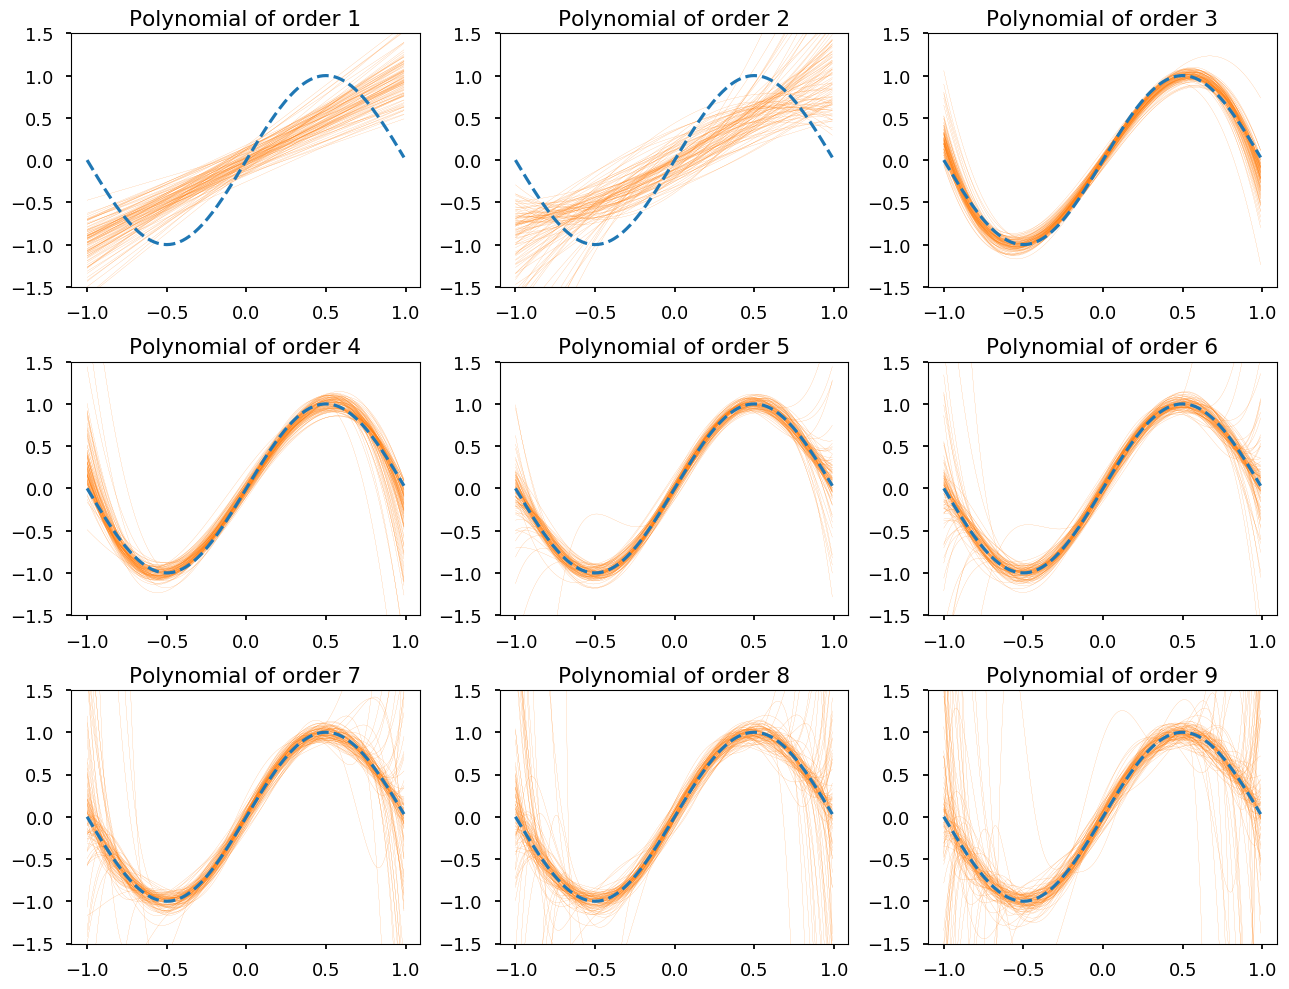

In [193]:
plt.figure(figsize=(13, 10))

for order in range(1, 10):
  plt.subplot(3, 3, order)
  plt.ylim([-1.5,1.5])

  for g in fits[order - 1]:
    plt.plot(x_, g(x_), 'C1-', linewidth=0.1)

  plt.plot(x_, np.sin(np.pi * x_), 'C0--')
  
  plt.title("Polynomial of order {}".format(order));
  
plt.tight_layout();

### Training and test errors

* In real life is impossible (unless one creates data by hand) to calculate true variance and bias

* One would need all possible datasets $D$ and all possible input values $x$

* Thus, usually one looks at training and test errors

    * Training error is measured on the data used to make a fit
    
    * Test/validation error is measured on unseen data

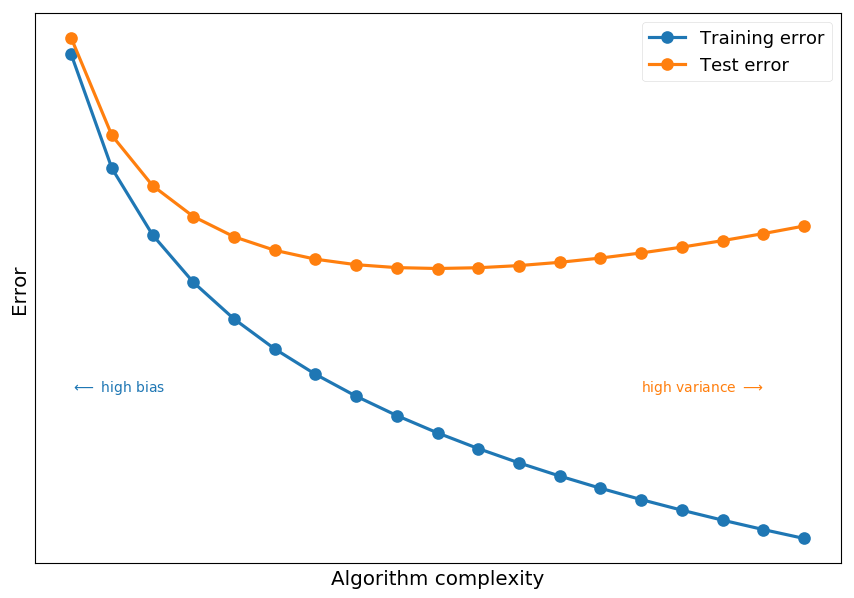

In [560]:
# fake error
complexity = np.arange(0.1, 2, 0.1)
train_error = -np.log(complexity)
test_error = -np.log(complexity) + np.power(complexity, 1)

plt.xticks([])
plt.yticks([])

plt.xlabel("Algorithm complexity")
plt.ylabel("Error")

plt.plot(complexity, train_error, 'C0o-', label='Training error')
plt.plot(complexity, test_error, 'C1o-', label="Test error")

plt.text(0.1, 0.25, "$\longleftarrow$ high bias", color='C0')
plt.text(1.5, 0.25, "high variance $\longrightarrow$", color='C1')

plt.legend();

* High training error indicates high bias (which means underfitting)

* Training error must decrease with model complexity

* If the training error is high:

    * Use more complex model (or new model architecture)
    
    * Use more features - maybe there is just not enough information to make a good prediction
    
    * Train longer (if the algorithm is an iterative optimization problem)
    
    * Decrease regularization (next lecture)

* Test error deacreses with model complexity up to a point when algorithm is to sensitive to features seen in training data

* If test error starts to increase it indicates high variance (which means overfitting)

* If test error is high:

    * Use more data - easy to say hard to do...
    
    * Use less features
    
    * Increase regularization 
    
    * Use different model

## Ensemble learning

* Lets first define a *weak learner* as a classifier which is just slighlty better than random guessing

* The idea behind ensemble learning is to create a *strong learner* as a combination of many *weak learners*

* We will discuss two popular ensemble methods:

    * Bagging (**b**ootstrap **agg**regat**ing**), e.g. random forest
        
    * Boosting, e.g. boosted decision tress

### Random forest

* Once we know a way to produce a tree we can create a forest

* And each tree contributes to a final prediction

* It is a *random* forest, because each tree is randomly *incomplete* - trained only on a random subsets of samples and features (*features bagging*)

* The final prediction of a random forest is an avearge predictions (for regression) or a majority vote (classification)

#### Intuitive / naive example

* Imagine you want to go to a cinema and need to choose a movie to watch

* You can ask a friend about the recommendation

    * She/he would ask you about movies you watched in the past
    
    * and (based on your answers) create a set of rules (a decision tree)
    
    * to finally recommend you a movie (make a prediction)
    
* Alternatively, you can ask many friends for an advice

    * Each friend would ask you random questions to give an answer
    
    * At the end, you choose a movie with most votes

#### The algorithm

* Lets imagine we have $N$ samples in our dataset (e.g. $N$ movies you watched)

* Each sample has $M$ features (e.g. do you like a movie? do you like the leading actor / actress or director?)

* To create a tree take $n$ random samples from the dataset and **at each node** select $m << M$ features ($m \sim \sqrt M$) to find the best predictor

* Repeat the procedure for next trees until you reach desired size of a forest

```
                    +------------+
                    |            |
                    |   Dataset  |
         +----------+            +----------+
         |          | N features |          |
         |          |            |          |
         v          +------------+          v                    Hyperparameters:

+-----------------+                 +-----------------+
|                 |                 |                 |
| Random subset 1 |      . . .      | Random subset T |
|                 |                 |                 |              - the number of trees
|   N features    |                 |   N features    |              - the size of subsets
|                 |                 |                 |
+--------+--------+                 +--------+--------+
         |                                   |
         v                                   v

+-----------------+                 +-----------------+
|                 |                 |                 |
|     Tree 1      |      . . .      |     Tree T      |
|                 |                 |                 |
+--------+--------+                 +-----------------+
         |
         |          +-------------+          +--------+
         |          |             |          |        |
         +--------> | M1 features +--------> | Node 1 |              - the number of random features
         |          |             |          |        |              - the size of a single tree
         |          +-------------+          +--------+
         |
         |          +-------------+          +--------+
         |          |             |          |        |
         +--------> | M2 features +--------> | Node 2 |
         |          |             |          |        |
         |          +-------------+          +--------+

                           .
                           .
                           .

```

### Boosted trees

* The idea is similar to bagging

* The key differences are:

    * Data is reweighted every time a *weak learner* is added (so future learners focus on misclassified samples)
    
    * The final prediction is weighted average (better classifiers have higher weights)

```
                            Bagging (parallel)

       +--------------------+                +----------------+
       |                    |                |                |
+----> |      Dataset       +--------------> | Weak learner 1 |
|      |                    |                |                |
|      +--------------------+                +----------------+
|
|
|      +--------------------+                +----------------+
|      |                    |                |                |
+----> |      Dataset       +------------->  | Weak learner 2 |
|      |                    |                |                |
|      +--------------------+       .        +----------------+
|                                   .
|                                   .
|      +--------------------+                +----------------+
|      |                    |                |                |
+----> |      Dataset       +------------->  | Weak learner N |
       |                    |                |                |
       +--------------------+                +----------------+

```

$\hspace{140pt}\text{output} = \frac{1}{N}\sum \text{output}_i$ 

<hr>

```
                          Boosting (sequential)

      +--------------------+                +----------------+
      |                    |                |                |
      |      Dataset       +--------------> | Weak learner 1 |
      |                    |                |                |
      +--------------------+                +--------+-------+
                                                     |
                +------------------------------------+
                |
                v

      +--------------------+                +----------------+
      |                    |                |                |
      | Reweighted dataset +------------->  | Weak learner 2 |
      |                    |                |                |
      +--------------------+                +--------+-------+
                                                     |
                +------------     . . .      --------+
                |
                v

      +--------------------+                +----------------+
      |                    |                |                |
      | Reweighted dataset +------------->  | Weak learner N |
      |                    |                |                |
      +--------------------+                +----------------+
                                                                        
```

$\hspace{130pt}\text{output} = \sum w_i\cdot \text{output}_i$ 

#### AdaBoost

* AdaBoost is on of the most famous algorithms in machine learning

* Y. Freund and R. Schapire got a Gödel Prize for this

* Lets consider $N$ labled training examples $(x_1, y_1), \cdots, (x_N, y_N)$, where $x_i \in X$ and $y_i = \left\{-1, 1\right\}$

* The initial distribution is initizlized with $D_1(i) = \frac{1}{N}$, where $i = 1, \cdots, N$ (so every sample is equaly likely)

* For $t = 1, \cdots, T$:

    * train a weak learner using $D_t$, $h_t: X \rightarrow \left\{-1, 1\right\}$
    
    * choose the one which minimizes the weighted error <p align="center">$\epsilon_t = \sum\limits_{i=1}^{N}D_t(i)\delta\left(h_t(x_i)\neq y_i\right)$</p>
    
    * calculate $\alpha_t$ <p align="center">$\alpha_t = \frac{1}{2}\ln\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$</p>
    
    * For $i = 1, \cdots, N$ update weights according to <p align="center">$D_{t+1} = \frac{D_t(i)}{Z_t}\begin{cases}e^{-\alpha_t} & h_t(x_i) = y_i \\ e^{\alpha_t} & h_t(x_i) \neq y_i \end{cases} = \frac{D_t(i)}{Z_t}e^{-\alpha_ty_ih_t(x_i)}$</p>
    
    * $Z_t$ is a normilization factor so $D_{t+1}$ is a distribution <p align="center">$Z_t = \sum\limits_{i=1}^ND_t(i)e^{-\alpha_ty_ih_t(x_i)}$</p>
    
* The final hyptohesis $H$ is computes the sign of a weighted combination of weak hypotheses <p align="center">$H(x) = \text{sign}\left(\sum\limits_{t=1}^T\alpha_th_t(x)\right)$</p> 

### Out-of-bag error

* Out-of-bag (OOB) error may be used for machine learning models using bootstrap aggregation (like random forest and boosted trees) instead of cross-validation

* Bagging involves random sampling with replacement

* Some samples are not used in the training process (out-of-bag samples) and therefore can be used to calculate test error

* OOB error is the average error over all training samples calculated using predictions from weak classifiers which do not contain particular sample in their bootstrap samples

### Example

* Lets consider some fake data generated with `make_blobs` from `scikit-learn`

* and then apply decision trees with different maximum depths

* and random forests with different maximum depths

#### Dataset

* `sklearn.datasets.make_blobs` allows to generate random Gaussian blobs

* We generate 8 blobs with fixed random generator (just to make sure we get the same set every time)

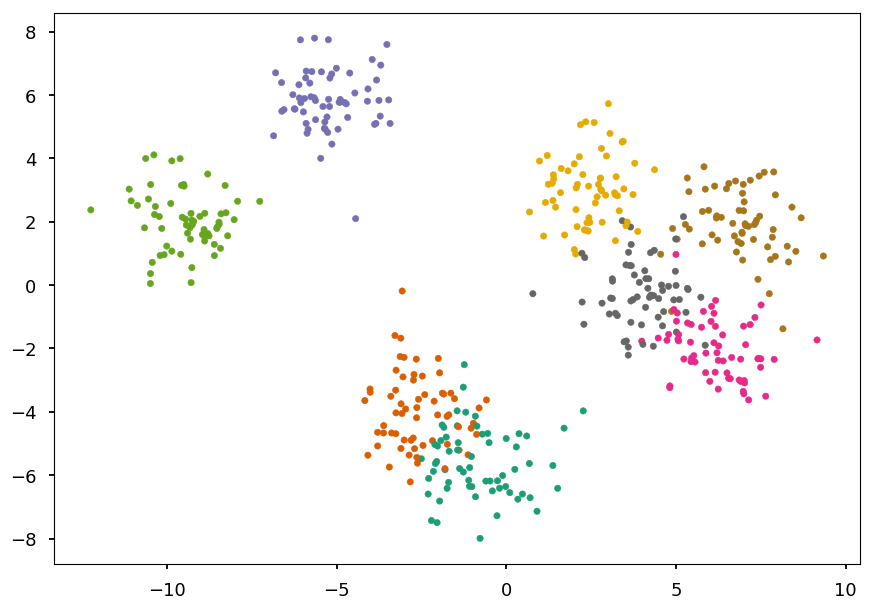

In [11]:
from sklearn.datasets import make_blobs

# generate 5 blobs with fixed random generator
X, Y = make_blobs(n_samples=500, centers=8, random_state=300)

plt.scatter(*X.T, c=Y, marker='.', cmap='Dark2');

#### Train and visualize

* To make our life easier we create a function to

    * plot training data on existing axes or new one (if not provided)
    
    * train given classifier on given dataset
    
    * create countours representing predictions of the classifier

In [0]:
def train_and_look(classifier, X, Y, ax=None, title='', cmap='Dark2'):
  """Train classifier on (X,Y). Plot data and prediction."""
  # create new axis if not provided
  ax = ax or plt.gca();
  
  ax.set_title(title)
    
  # plot training data
  ax.scatter(*X.T, c=Y, marker='.', cmap=cmap)
  
  # train a cliassifier
  classifier.fit(X, Y)

  # create a grid of testing points
  x_, y_ = np.meshgrid(np.linspace(*ax.get_xlim(), num=200),
                       np.linspace(*ax.get_ylim(), num=200))

  # convert to an array of 2D points
  test_data = np.vstack([x_.ravel(), y_.ravel()]).T
  
  # make a prediction and reshape to grid structure 
  z_ = classifier.predict(test_data).reshape(x_.shape)
  
  # arange z bins so class labels are in the middle
  z_levels = np.arange(len(np.unique(Y)) + 1) - 0.5
  
  # plot contours corresponding to classifier prediction
  ax.contourf(x_, y_, z_, alpha=0.25, cmap=cmap, levels=z_levels)

* Let check how it works on a decision tree classifier with default `sklearn` setting

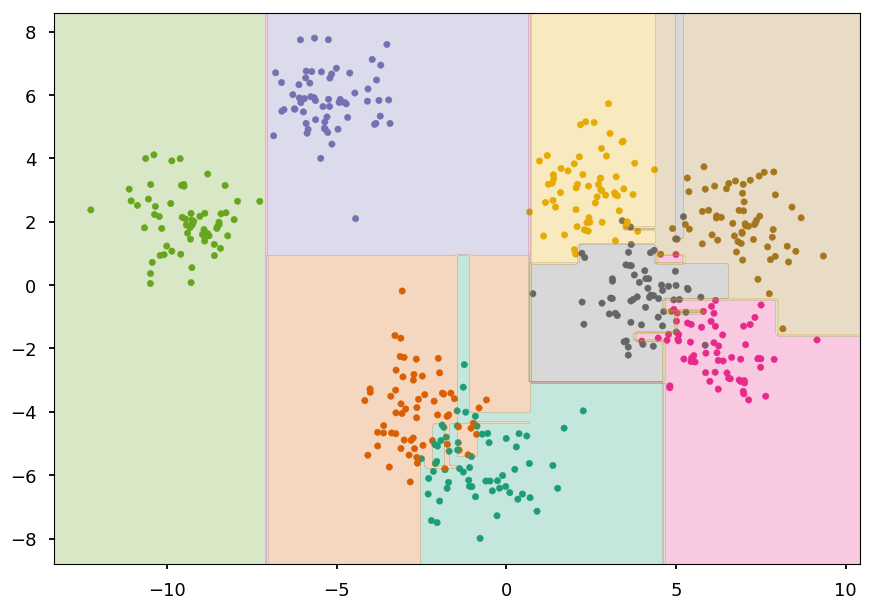

In [12]:
from sklearn.tree import DecisionTreeClassifier as DT

train_and_look(DT(), X, Y)

#### Decision tree

* We consider decision trees with fixed maximum depths from 1 to 9

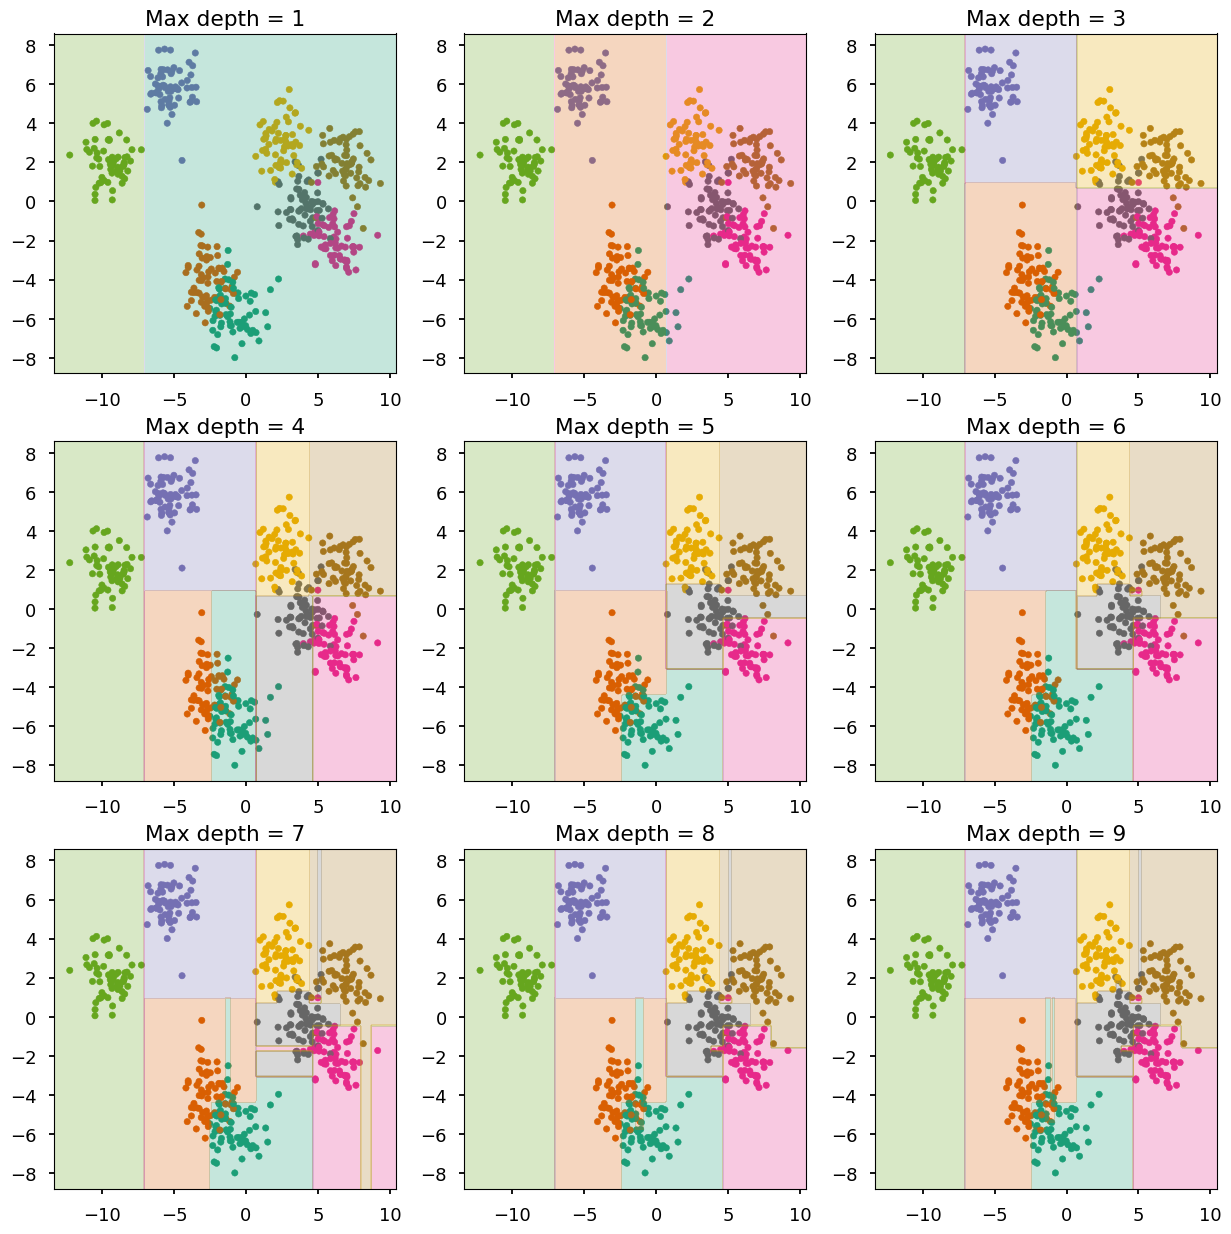

In [13]:
# create a figure with 9 axes 3x3
fig, ax = plt.subplots(3, 3, figsize=(15,15))

# train and look at decision trees with different max depth
for max_depth in range(0, 9):
  train_and_look(DT(max_depth=max_depth + 1), X, Y,
                 ax=ax[max_depth // 3][max_depth % 3],
                 title="Max depth = {}".format(max_depth + 1))

* `max_depth` <= 3 - undefitting
* `max_depth` <= 6 - quite good
* `max_depth`  > 6 - overfitting

#### Random forest

* Lets do the same with random forests (100 trees in each forest)

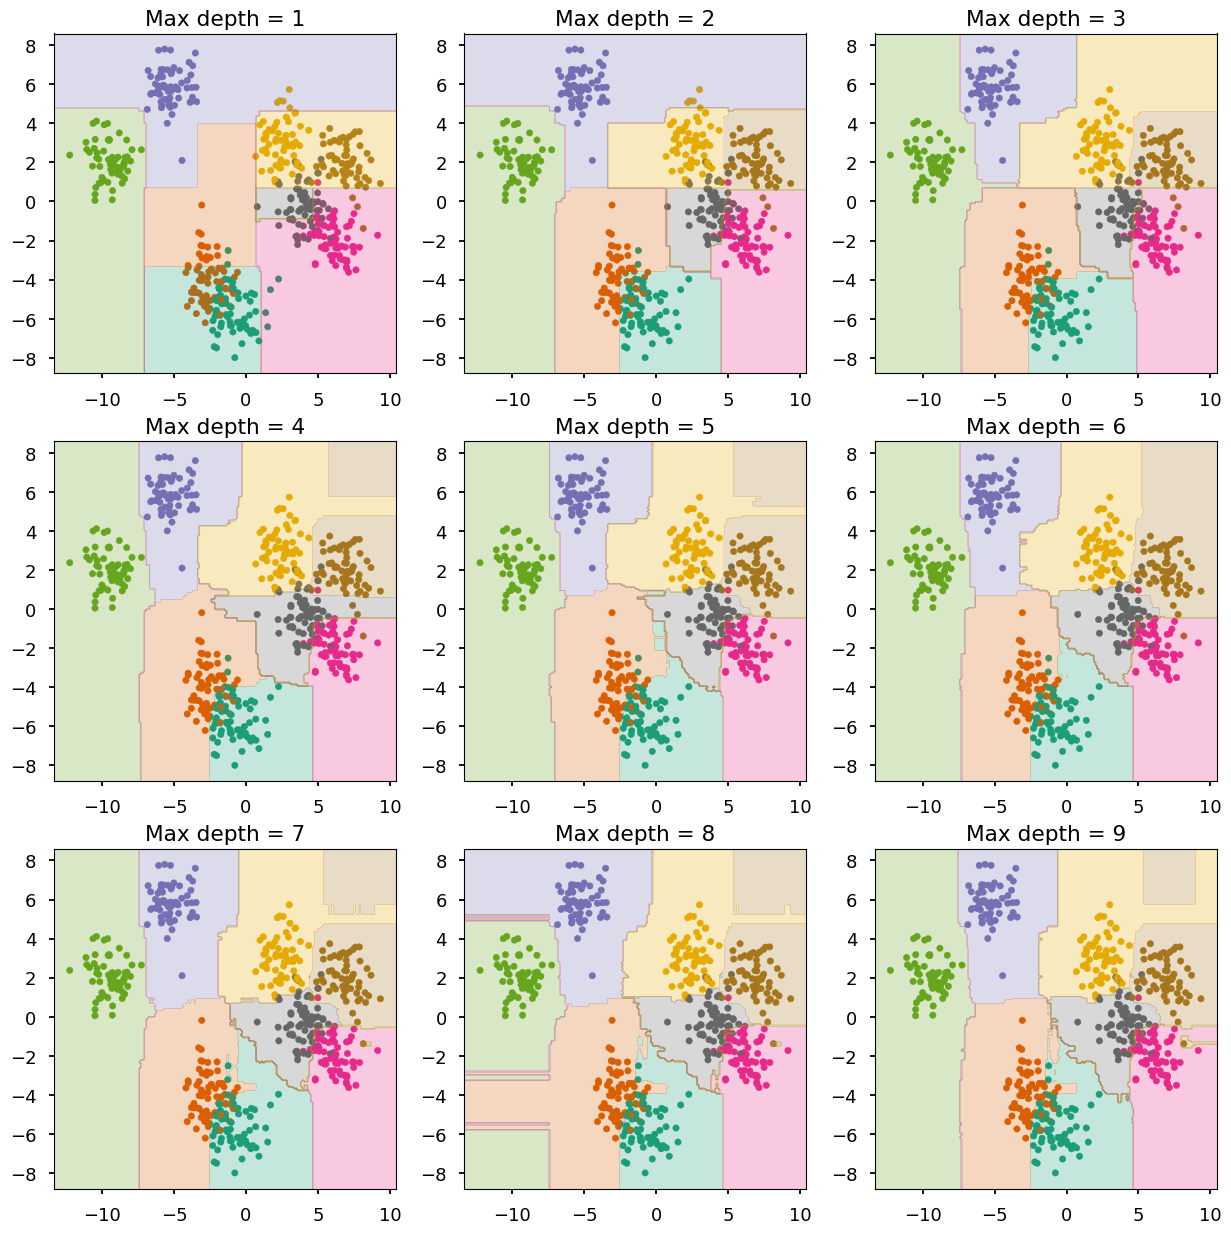

In [14]:
from sklearn.ensemble import RandomForestClassifier as RF

# create a figure with 9 axes 3x3
fig, ax = plt.subplots(3, 3, figsize=(15,15))

# train and look at decision trees with different max depth
for max_depth in range(0, 9):
  train_and_look(RF(n_estimators=100, max_depth=max_depth + 1), X, Y,
                 ax=ax[max_depth // 3][max_depth % 3],
                 title="Max depth = {}".format(max_depth + 1))

* The combination of shallow trees (weak learners) does a good job

* Overfitting is somehow prevented 

## Summary

* The most important lesson today: **bias-variance trade-off**

    * For the lecture easy examples are chosen so they can be visualize
    
    * In real life problems, it is hard / impossible to determine using "bye eye" method if the model is underfitted or overfitted
    
    * Note, that actually you should never used this method even if you think "your eye" is right - you would be surprised how it is not
    
    * One needs a way to measure the goodnes of a model - usually mean squared error
        
    * In practice, most people use cross-calidation technique 
    
* The biggest advantages of decision trees algoritms is that they are east to interpret (it is easy to explain even to non-experts how they work, which is not the case with e.g. deep neural networks)

* Usually, decision trees are used as weak learners in ensemble learning

* The most famous boosting algorithm is AdaBoost, because it is a good one and the first one. Although, there are many other boosting methods on market right now with XGBoost being one of the most popular one

* As for today, deep learning has better publicity, but boosted trees are still one of the most common algorithms used in [Kaggle competitions](https://www.kaggle.com/)

* Boosted trees are also popular among physicist and used by them as an alternative to neural networks for experimental elementary particle physics in event reconstruction procedures 
